In [1]:
import sys
sys.path.append("..")

In [2]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
#import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    # workaround for jax bug on GPUs
    # https://github.com/jax-ml/jax/issues/24909
    jax.config.update("jax_default_matmul_precision", "float32")
    # configure numpyro to use GPU
    numpyro.set_platform("gpu")

from jax.extend.backend import get_backend
print(f"current device: {get_backend().platform}")

import weathergen as wx
import wxsbi

current device: gpu


In [3]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

# Data

In [4]:
import weathergen.data

name_map = weathergen.data.data_var_name_map(prec="pr", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax", time = "date")
dataset = wx.data.load_time_series_csv("../data/potsdam.csv", name_map)

# Choose training period
calibration_data = dataset["1950":"1999"]

# Remove two datapoints where Tmin == Tavg
calibration_data = calibration_data.drop(index=calibration_data.iloc[[6579, 6994], :].index)

In [5]:
assert np.all(calibration_data["Tair_min"] < calibration_data["Tair_mean"])
assert np.all(calibration_data["Tair_min"] < calibration_data["Tair_max"])
assert np.all(calibration_data["Tair_mean"] < calibration_data["Tair_max"])
assert np.all(calibration_data["prec"] >= 0)

# Model

In [6]:
from weathergen.wgen.wgen_gamlss import *

In [7]:
wgen = wx.WGEN(calibration_data, model = WGEN_GAMLSS(), order = 2, Tair_freqs=[1/365.25, 2/365.25], prec_freqs=[1/365.25, 2/365.25])

Run variational inference for parameter estimates:

In [8]:
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal

num_iter = 50_000
prng = random.PRNGKey(1234)
guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
#guide = AutoNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)

svi_result = wgen.fit(num_iter, guide, subsample_time=1000, rng=prng)


100%|██████████| 50000/50000 [01:15<00:00, 658.23it/s, init loss: 5652193.0000, avg. loss [47501-50000]: 44089.2578]


Get posterior samples:

In [9]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=1000)
posterior_params = posterior_sampler(prng)
{k: v.mean(axis=0) for k,v in posterior_params.items() if k != "_auto_latent"}

{'Tavg_loc_lag': Array([-0.14746101,  0.91280067], dtype=float32),
 'Tavg_loc_pred': Array([2.3717031], dtype=float32),
 'Tavg_loc_scale_pred': Array([0.7969069], dtype=float32),
 'Tavg_loc_scale_seasonal': Array([ 0.07562284, -0.0447648 ,  0.04190811,  0.0846374 ], dtype=float32),
 'Tavg_loc_seasonal': Array([-0.667298  ,  0.10684851, -2.6650677 ,  0.16250956], dtype=float32),
 'Tavg_loc_seasonal_lag_interaction': Array([-0.01134208,  0.02625033, -0.00886484,  0.00325981,  0.03837875,
        -0.01491038,  0.06220222, -0.00227213], dtype=float32),
 'Trange_disp_lag': Array([0.01388818, 0.09810804], dtype=float32),
 'Trange_disp_lag_seasonal_interaction': Array([-0.05003851, -0.03008706,  0.1099513 , -0.02330322, -0.02404142,
         0.05235722, -0.01986126, -0.02358462], dtype=float32),
 'Trange_disp_pred': Array([-0.25257635], dtype=float32),
 'Trange_disp_seasonal': Array([ 0.06121286, -0.02323655,  0.05571753, -0.22324459], dtype=float32),
 'Trange_mean_Tavg': Array([0.6180875], d

Get predictive distributions and run simulations

In [10]:
svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
svi_preds = svi_predictive(prng)

In [11]:
obs = wgen.obs

In [12]:
from weathergen.plotting import *

In [13]:
obs["Tmin"] = obs["Tavg"] - obs["Trange"] * obs["Tskew"]
obs["Tmax"] = obs["Tmin"] + obs["Trange"]

## Model diagnostics

In [14]:
sns.color_palette("Purples_d", 4) # Dark2, Reds, Purples, crest, flare

[(0.6551633986928105, 0.6405228758169934, 0.8091503267973856),
 (0.5338562091503267, 0.5019607843137255, 0.7359477124183006),
 (0.41856209150326795, 0.38614379084967315, 0.5994771241830065),
 (0.30928104575163395, 0.2930718954248366, 0.39973856209150327)]

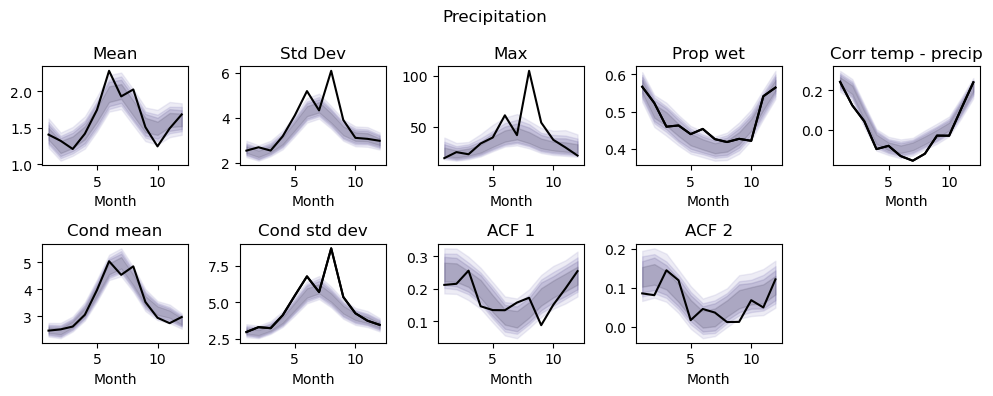

In [15]:
fig = plt.figure(layout="tight", figsize=(10, 4))
fig.suptitle("Precipitation")

gs = GridSpec(2, 5, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(5)]
get_mean_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_max_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[2], colors = color_palette)
get_prop_wet_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[3], colors = color_palette)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_1[4], colors = color_palette)



# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(5)]
get_cond_mean_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_2[0], colors = color_palette)
get_cond_std_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_acf_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_2[2], lag=1, colors = color_palette)
get_acf_plot(obs["prec"], svi_preds["prec"], calibration_data.index, ax=ax_row_2[3], lag=2, colors = color_palette)
ax_row_2[4].axis("off")

plt.savefig("plots/pr_paper.png", dpi = 300)

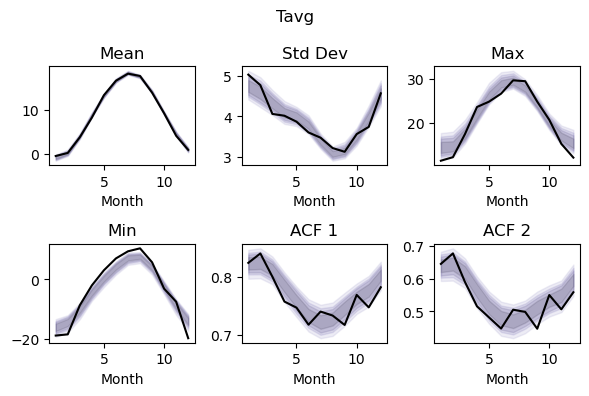

In [16]:
fig = plt.figure(layout="tight", figsize=(6, 4))
fig.suptitle("Tavg")

gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_max_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_1[2], colors = color_palette)

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_min_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_2[0], colors = color_palette)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_2[1], lag=1, colors = color_palette)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], calibration_data.index, ax=ax_row_2[2], lag=2, colors = color_palette)

plt.savefig("plots/tavg_paper.png", dpi = 300)

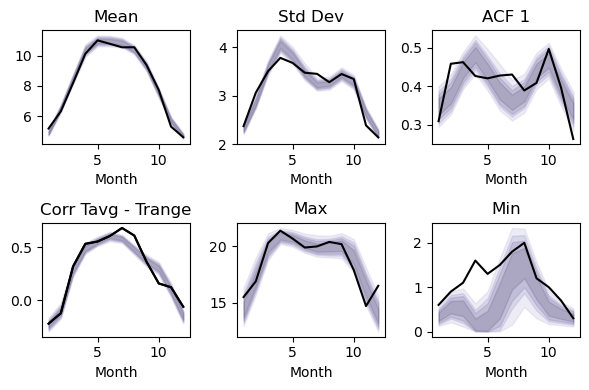

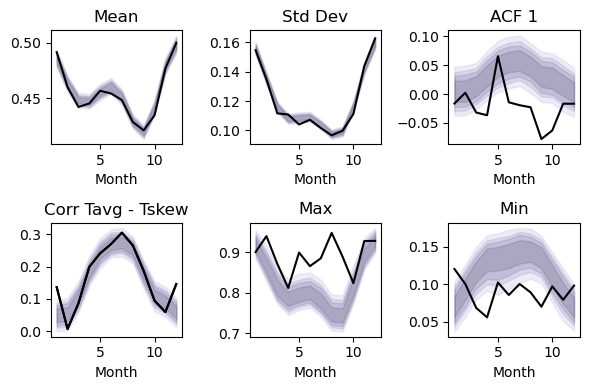

In [17]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Trange")

gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_acf_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_1[2], lag=1, colors = color_palette)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"], svi_preds["Trange"], calibration_data.index,  "Tavg", "Trange", ax=ax_row_2[0], colors = color_palette)
#get_acf_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_min_plot(obs["Trange"], svi_preds["Trange"], calibration_data.index, ax=ax_row_2[2], colors = color_palette)

plt.savefig("plots/trange_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tskew")
gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_acf_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_1[2], lag=1, colors = color_palette)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Tskew"], svi_preds["Tskew"], calibration_data.index, "Tavg", "Tskew", ax=ax_row_2[0], colors = color_palette)
#get_acf_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_min_plot(obs["Tskew"], svi_preds["Tskew"], calibration_data.index, ax=ax_row_2[2], colors = color_palette)

plt.savefig("plots/tskew_paper.png", dpi = 300)

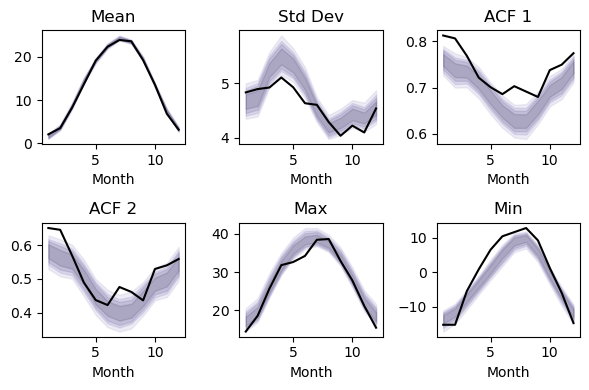

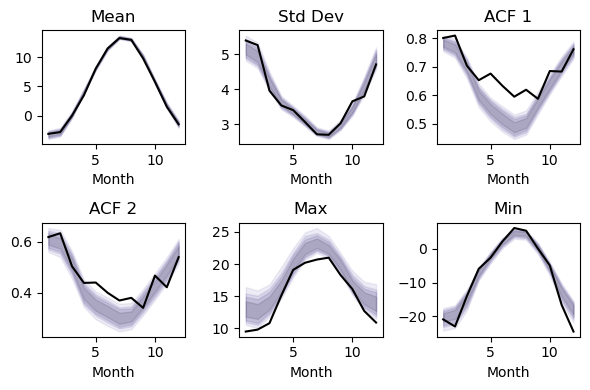

In [18]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmax")

gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_1[2], lag=1, colors = color_palette)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_2[0], lag=2, colors = color_palette)
get_max_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_min_plot(obs["Tmax"], svi_preds["Tmax"], calibration_data.index, ax=ax_row_2[2], colors = color_palette)

plt.savefig("plots/tmax_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmin")
gs = GridSpec(2, 3, figure=fig)
color_palette = sns.color_palette("Purples_d", 4)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_1[0], colors = color_palette)
get_std_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_1[1], colors = color_palette)
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_1[2], lag=1, colors = color_palette)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_2[0], lag=2, colors = color_palette)
get_max_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_2[1], colors = color_palette)
get_min_plot(obs["Tmin"], svi_preds["Tmin"], calibration_data.index, ax=ax_row_2[2], colors = color_palette)

plt.savefig("plots/tmin_paper.png", dpi = 300)

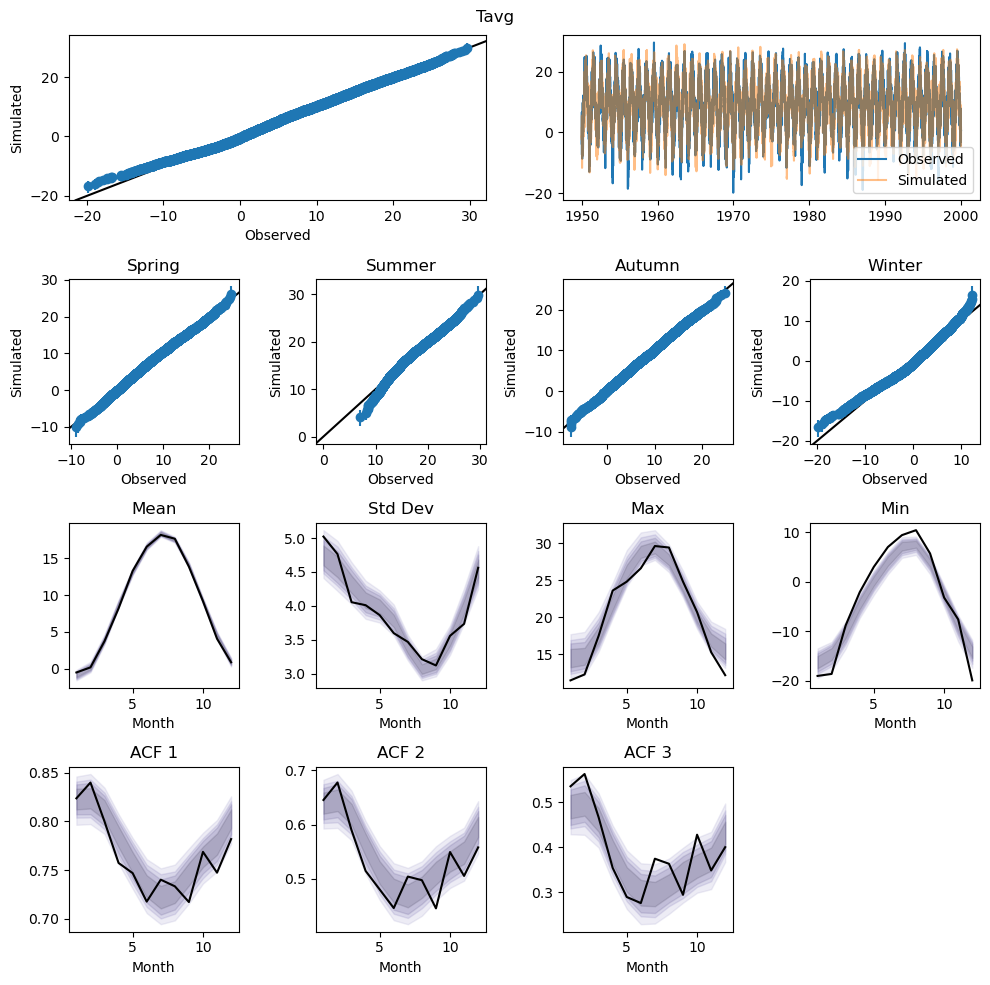

In [19]:
Tavg_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_Tavg.png")

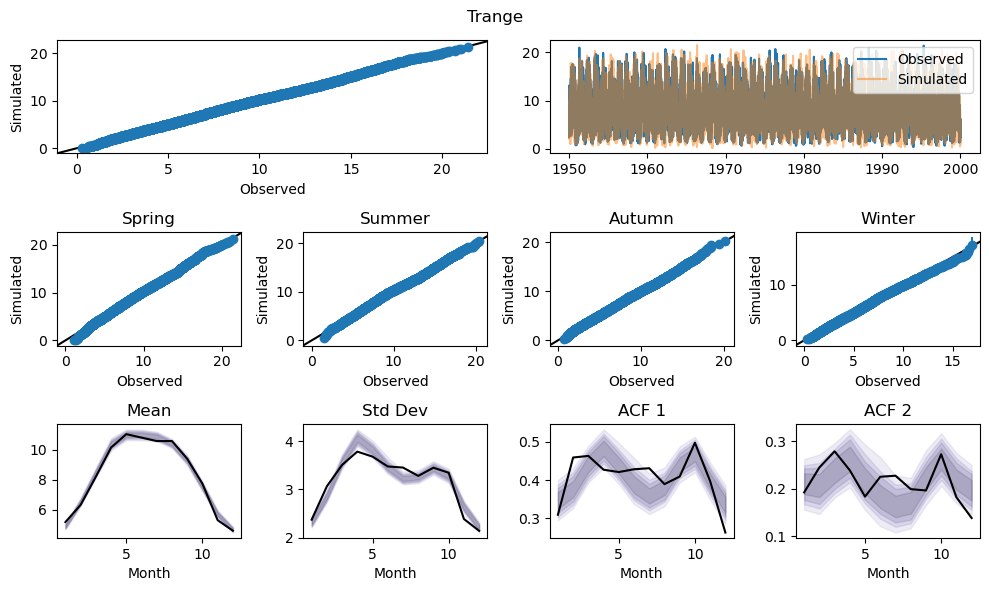

In [20]:
Trange_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_Trange.png")

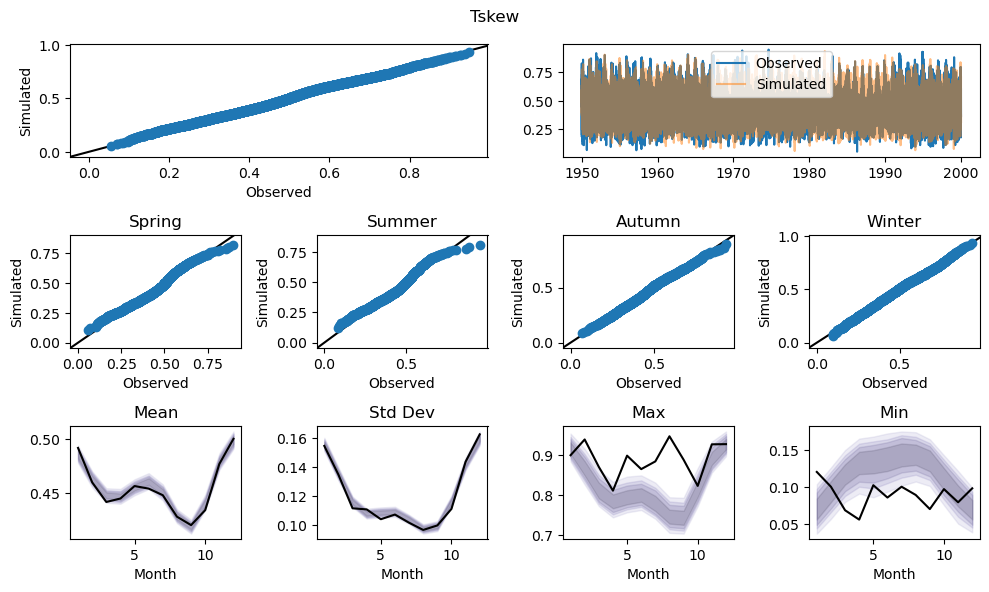

In [21]:
Tskew_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_Tskew.png")

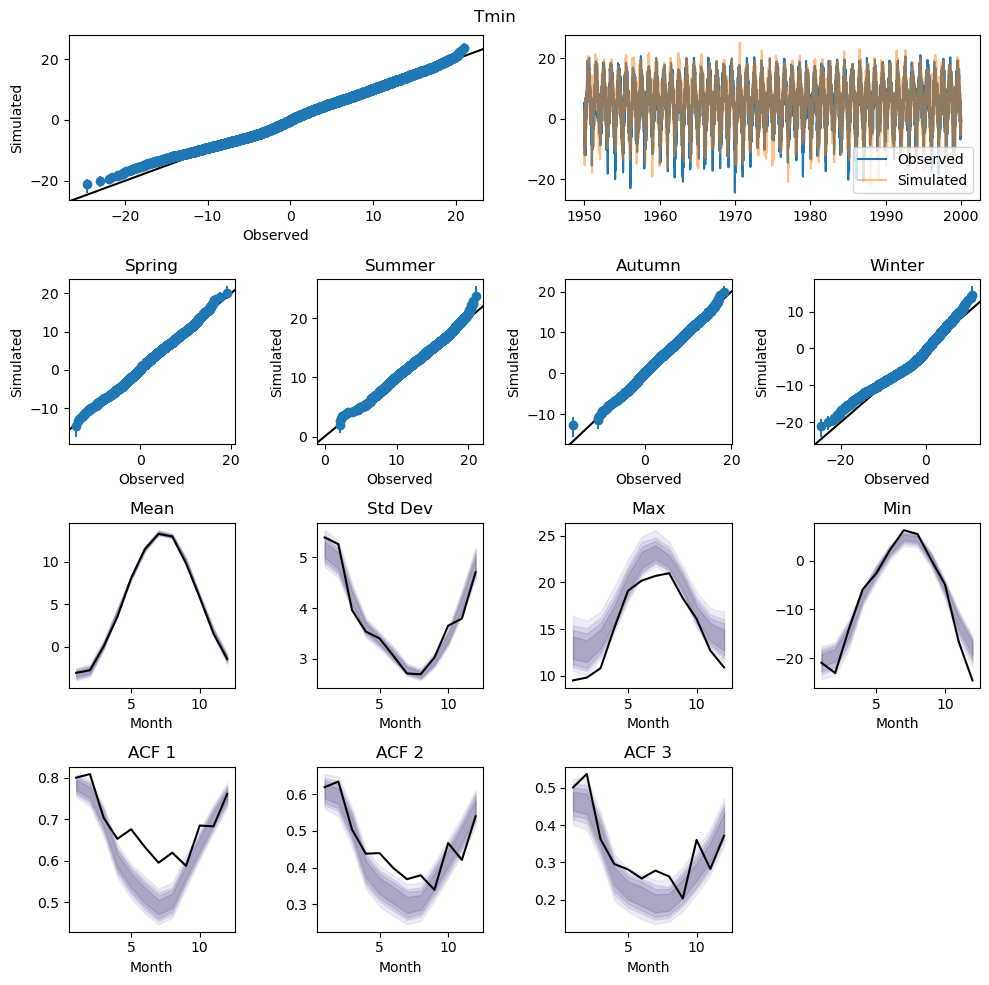

In [22]:
Tmin_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_Tmin.png")

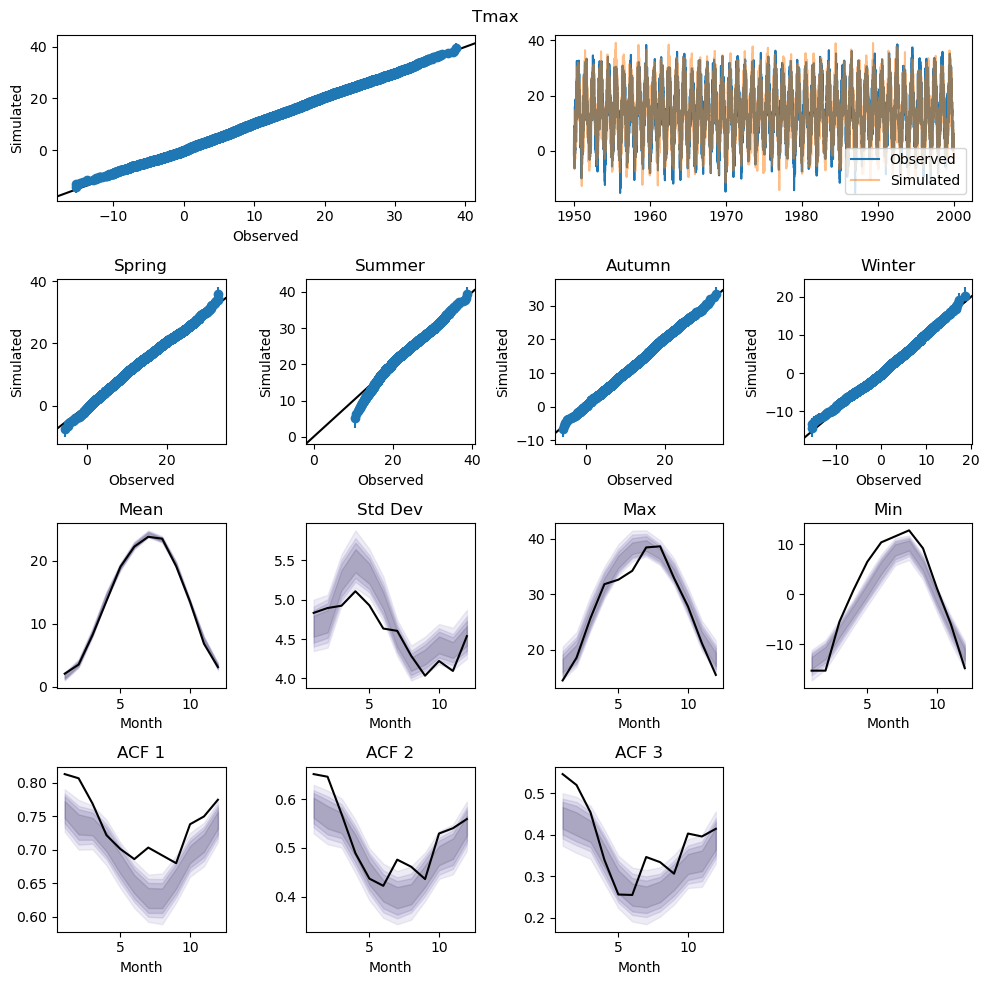

In [23]:
Tmax_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_Tmax.png")

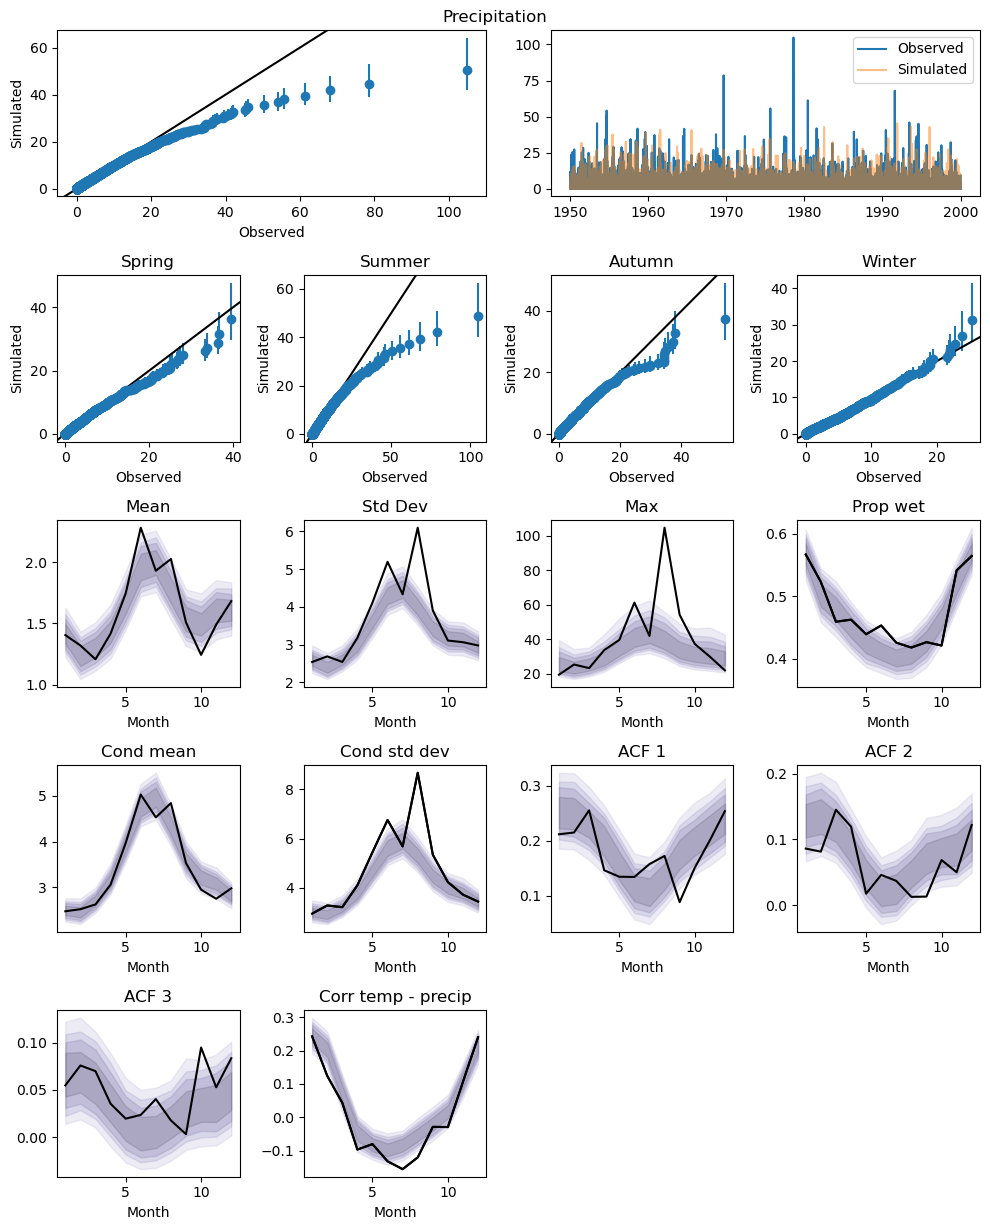

In [24]:
prec_overview(obs, svi_preds, calibration_data, colors = color_palette)
plt.savefig("plots/wgen_prec.png")

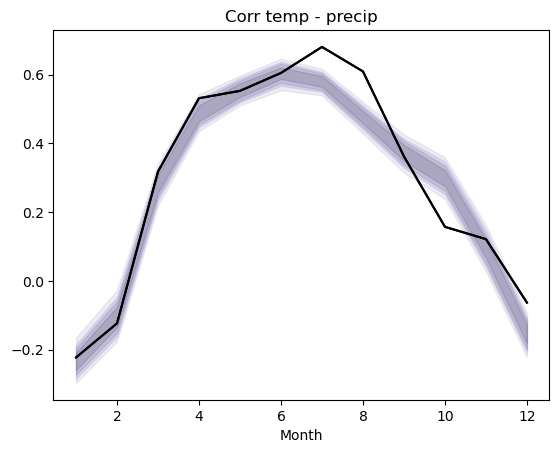

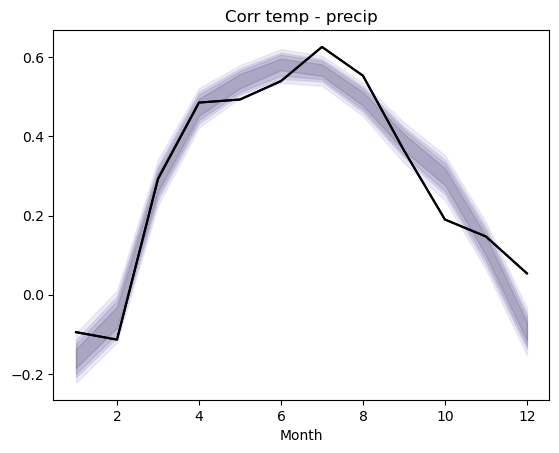

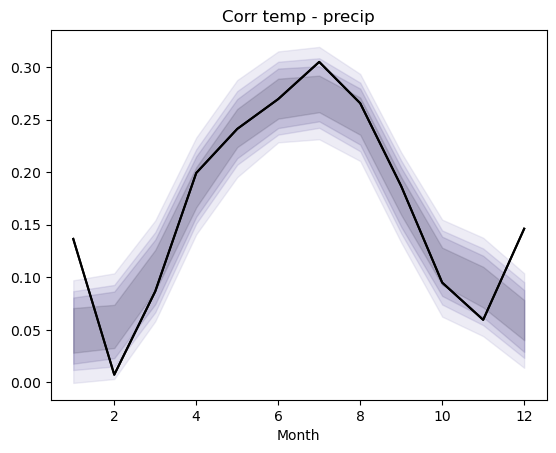

In [25]:
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"], svi_preds["Trange"], calibration_data.index, colors = color_palette)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"]*obs["Tskew"], svi_preds["Trange"]*svi_preds["Tskew"], calibration_data.index, colors = color_palette)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Tskew"], svi_preds["Tskew"], calibration_data.index, colors = color_palette)

# SBI

In [26]:
import torch
torch.manual_seed(1234)

In [27]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Case study 1a (Tavg, pr, dry days const.):

Trend in tavg, precip, dry days constant:

In [28]:
num_rounds = 10
num_simulations_per_round = 1000
batch_size = 1000

In [29]:
@wxsbi.summarystats("pmean", "pavgwet", "Tavgmean")
def case_study_1a(prec, Tavg, **kwargs):
    pmean = jnp.mean(prec, axis = -1)
    pavgwet = jnp.mean(prec > 0, axis = -1)
    Tavgmean = jnp.mean(Tavg, axis = -1)
    return jnp.stack([pmean, pavgwet, Tavgmean], axis = -1)

In [30]:
obs_stats = case_study_1a(**obs).flatten()
obs_stats

Array([1.6045674, 0.4748631, 8.81644  ], dtype=float32)

In [31]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.2) # 20% more precip
obs_stats_target = obs_stats_target.at[2].add(3.5) # +3.5 degC avg temp.
obs_stats_target

Array([ 1.925481 ,  0.4748631, 12.31644  ], dtype=float32)

In [32]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew", "precip_occ_"])

simulator = wxsbi.build_simulator(wgen, case_study_1a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask = parameter_mask, scale_factor = 2.5)

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean


100%|██████████| 2/2 [00:27<00:00, 13.98s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:27<00:00, 13.75s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:27<00:00, 13.99s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi.wxsbi:Training estimator


 Neural network successfully converged after 110 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 106 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 46

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 47 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 59

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 60 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 30

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 31 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 69

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 70 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 32

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 33 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 21

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 22 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:27<00:00, 13.90s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:27<00:00, 13.78s/it]


6.193082869052887


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'pmean'}>,
        <Axes: title={'center': 'pavgwet'}>,
        <Axes: title={'center': 'Tavgmean'}>], dtype=object))

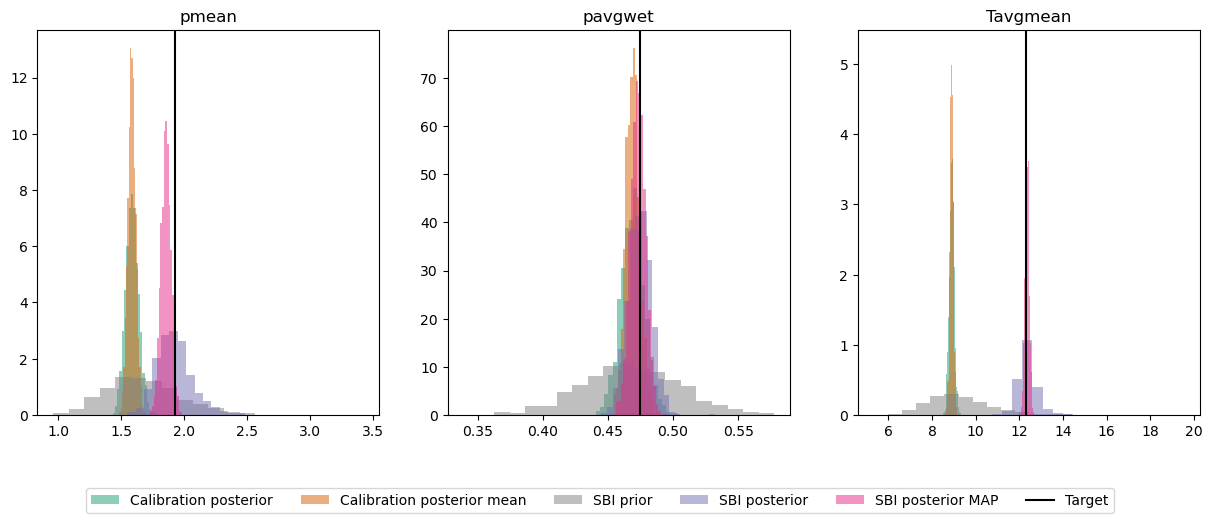

In [33]:
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params),
                       num_samples = 2000, num_rounds = num_rounds, batch_size = batch_size,
                       simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
#result.to_file("sbi_results/case_study_1a.pkl")

## Case study 1b (as 1a but dry day prior scaled up, not included in paper):

Trend in tavg, precip, dry days constant:

In [34]:
num_rounds = 10
num_simulations_per_round = 1000
batch_size = 1000

In [35]:
obs_stats = case_study_1a(**obs).flatten()
obs_stats

Array([1.6045674, 0.4748631, 8.81644  ], dtype=float32)

In [36]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)
obs_stats_target

Array([ 1.925481 ,  0.4748631, 12.31644  ], dtype=float32)

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:28<00:00, 14.08s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.30s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:27<00:00, 13.89s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


 Neural network successfully converged after 100 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 132 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 63

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 64 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 47

INFO:wxsbi.wxsbi:Starting round 5/10


 Neural network successfully converged after 48 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 22

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 23 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 29

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 30 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 57

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 58 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 29

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 30 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 53

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 54 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:29<00:00, 14.75s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:27<00:00, 13.90s/it]


6.408697998523712


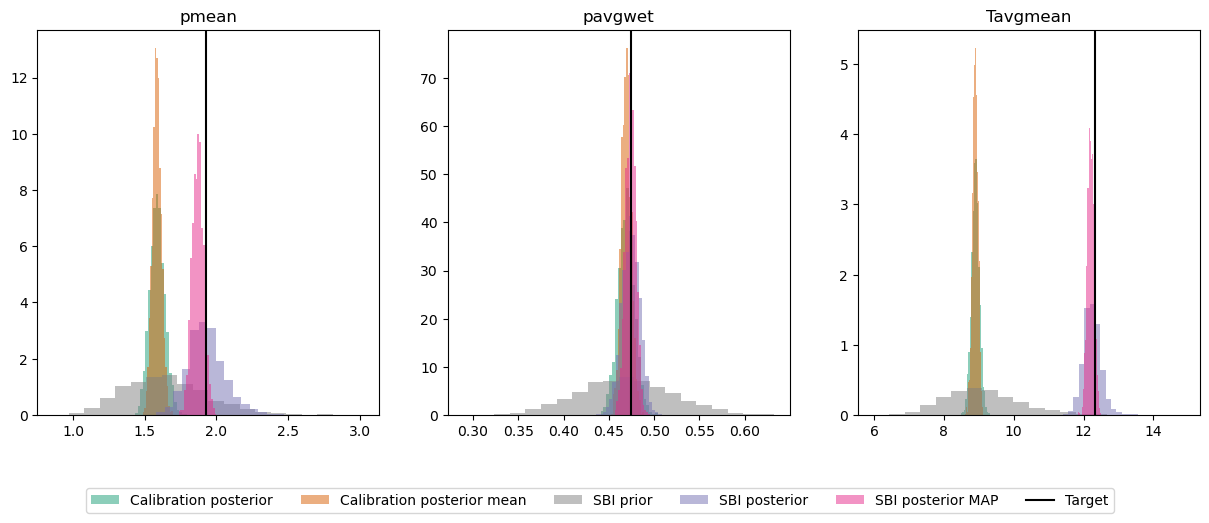

In [37]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_1a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_1b.pkl")

## Case study 2 (Tavg, pr, heavy rain, icy days, tropical night, Trange)

Note: $\gamma = 3.5$ here to make sure prior closer to target in statistic nr. 5 (tropical nights).

In [38]:
num_rounds = 10
num_simulations_per_round = 1000
batch_size = 1000

In [39]:
obs

{'prec': Array([[ 1.8, 11.1,  1. , ...,  0. ,  0.6,  0. ]], dtype=float32),
 'Tavg': Array([[-3.7,  0.4,  2.1, ...,  0.4,  0.4,  0.5]], dtype=float32),
 'Trange': Array([[4.2, 5.2, 2.3, ..., 2.4, 3. , 3. ]], dtype=float32),
 'Tskew': Array([[0.45238096, 0.8269231 , 0.39130434, ..., 0.375     , 0.46666667,
         0.36666667]], dtype=float32),
 'Tmax': Array([[-1.4000001,  1.3000002,  3.5      , ...,  1.9000001,  2.       ,
          2.4      ]], dtype=float32),
 'Tmin': Array([[-5.6      , -3.8999996,  1.1999999, ..., -0.5      , -1.       ,
         -0.6      ]], dtype=float32)}

In [40]:
@wxsbi.summarystats("Tavgmean", "pmean", "heavy_rain", "icy_days", "tropical_nights", "Trangemean")
def case_study_2(prec, Tmin, Tavg, Tmax, **kwargs):
    Tavgmean = jnp.mean(Tavg, axis = -1)
    
    pmean = jnp.mean(prec, axis = -1)
    heavy_rain = jnp.mean(prec > 20, axis = -1)

    icy_days = jnp.mean(Tmax < 0, axis = -1)
    tropical_nights = jnp.mean(Tmin > 20, axis = -1)

    Trangemean = jnp.mean(Tmax - Tmin, axis = -1)

    return jnp.stack([Tavgmean, pmean, heavy_rain, icy_days, tropical_nights, Trangemean], axis = -1)

obs_stats = case_study_2(**obs).flatten()
obs_stats

Array([8.8164396e+00, 1.6045674e+00, 7.2289160e-03, 6.6538885e-02,
       8.2146772e-04, 8.3253994e+00], dtype=float32)

In [41]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].add(3.1) # Tavg 
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean 
obs_stats_target = obs_stats_target.at[2].mul(2.) # heavy_rain
obs_stats_target = obs_stats_target.at[3].set(0.01) # icy_days: 3 per year
obs_stats_target = obs_stats_target.at[4].set(0.08) # tropical_nights: 30 per year
obs_stats_target = obs_stats_target.at[5].mul(1.2) # Trangemean

obs_stats_target

Array([1.1916439e+01, 2.0859375e+00, 1.4457832e-02, 9.9999998e-03,
       7.9999998e-02, 9.9904795e+00], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:27<00:00, 13.94s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.01s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:29<00:00, 14.56s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 103 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 190 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 105 epochs.

INFO:wxsbi.wxsbi:Starting round 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 47

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 48 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 61

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 62 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 37

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 38 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 32

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 33 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 42

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 43 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.04s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:29<00:00, 14.88s/it]


6.655700771013896


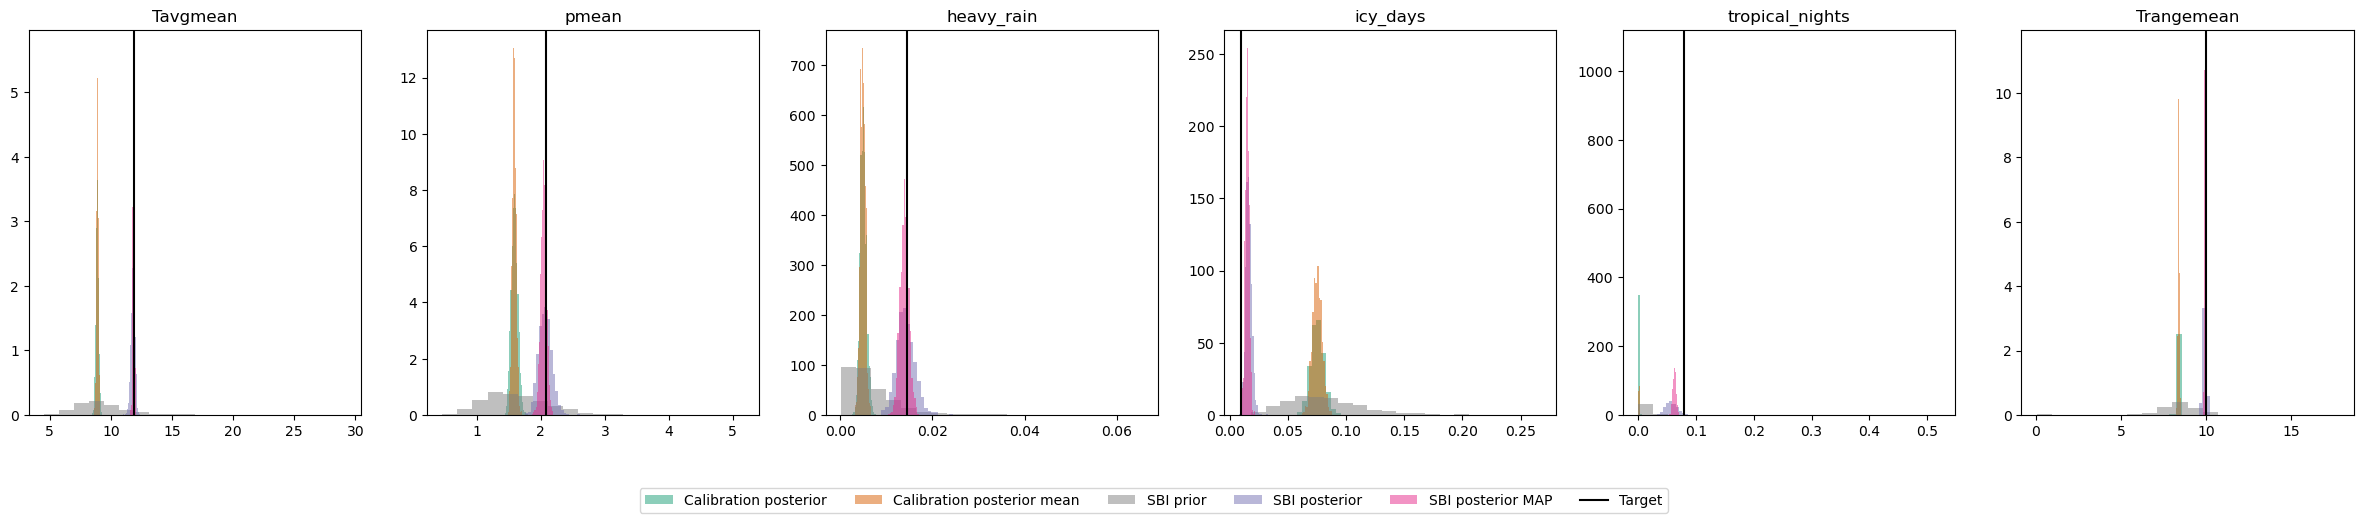

In [42]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["seasonal"])

simulator = wxsbi.build_simulator(wgen, case_study_2, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 4.0)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params),
                       num_samples = 2000, num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_2.pkl")

## Case study 3a (seasonal Tavg, pr, monthly dry days const)

In [43]:
num_rounds = 10
num_simulations_per_round = 1000
batch_size = 1000

In [44]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", *list(map(str, range(1,13))))
def case_study_3a(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    
    monthly_pavg_wet = []
    for i in range(1, 13):
        month = (t[:, :, 2] == i)
        pavgwet_month = jnp.nanmean(jnp.where(month, wet, jnp.nan), axis = -1)
        monthly_pavg_wet.append(pavgwet_month)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, *monthly_pavg_wet], axis = -1)#, icy_days])

obs_stats = case_study_3a(t = svi_preds['t'][:, :, :, :], **obs).mean(axis = 0).flatten()
obs_stats.shape

(20,)

In [45]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([ 1.9140847 ,  1.8918679 ,  2.075413  ,  1.6220818 ,  3.5786033 ,
       11.008175  , 20.57531   , 13.537079  ,  0.5668174 ,  0.5230332 ,
        0.45935467,  0.4626666 ,  0.43935487,  0.45333314,  0.42580634,
        0.41806442,  0.42666656,  0.4212904 ,  0.54133326,  0.5645161 ],      dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:27<00:00, 13.96s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.00s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.05s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 183 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.

INFO:wxsbi.wxsbi:Starting round 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

INFO:wxsbi.wxsbi:Starting round 6/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 48

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 49 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 33

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 34 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 57

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 58 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 33

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 34 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.03s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.03s/it]


6.421871546904246


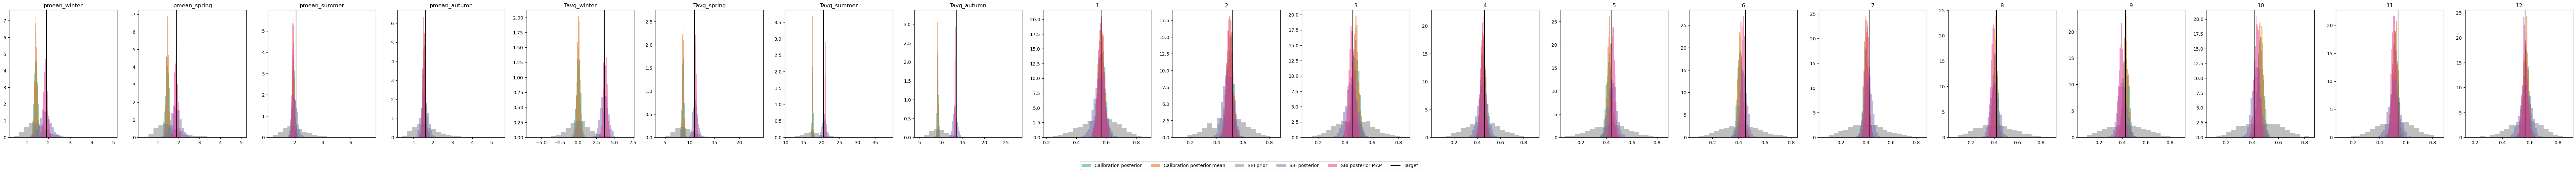

In [46]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3a.pkl")

## Case study 3b (seasonal Tavg, pr, overall dry days const, tight prior)

In [47]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3b(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    pavg_wet = jnp.nanmean(wet, axis = -1)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet], axis = -1)#, icy_days])

obs_stats = case_study_3b(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.4105059 ,  0.17860313,
        8.4081745 , 17.47531   ,  9.037079  ,  0.4748631 ], dtype=float32)

In [48]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([ 1.9140847,  1.8918679,  2.075413 ,  1.6220818,  3.5786033,
       11.008175 , 20.57531  , 13.537079 ,  0.4748631], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:29<00:00, 14.55s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.06s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.06s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 142 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.

INFO:wxsbi.wxsbi:Starting round 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

INFO:wxsbi.wxsbi:Starting round 6/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 30

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 31 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 38

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 39 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 24

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 25 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 49

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 50 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.08s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.46s/it]


6.304012123743693


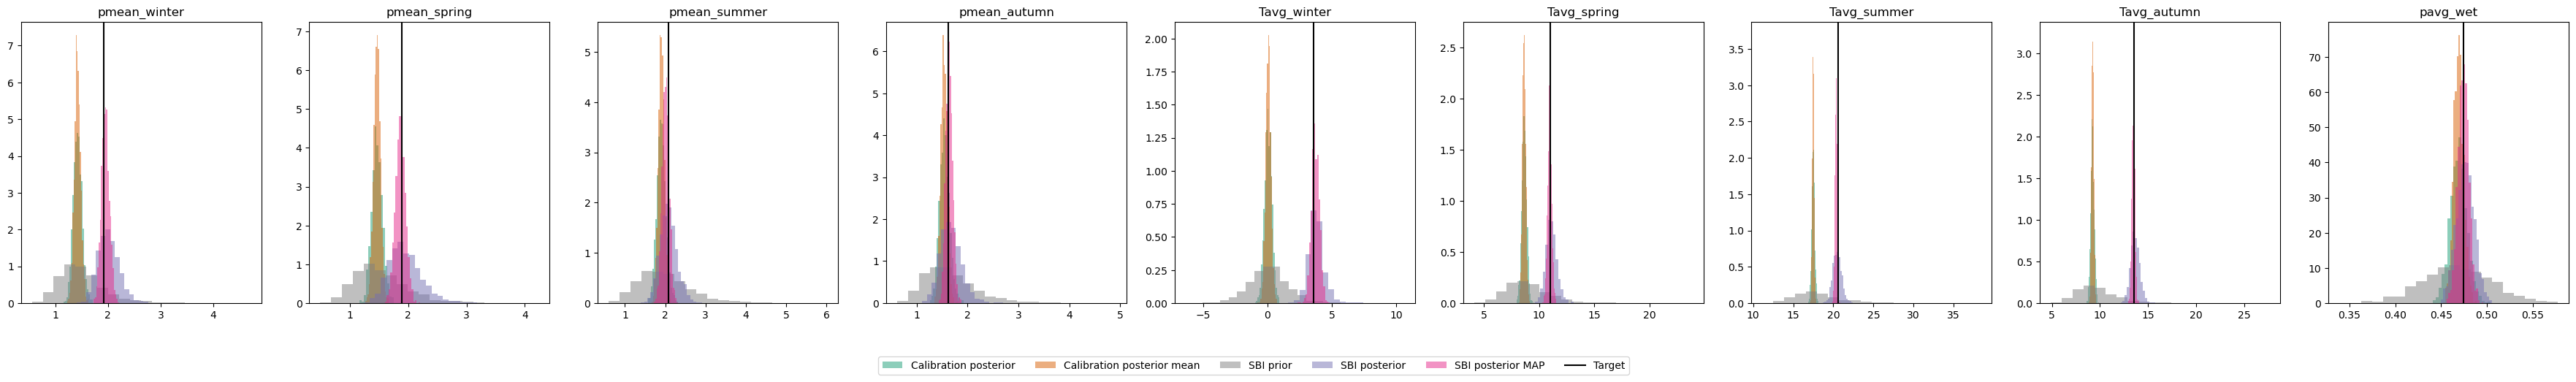

In [49]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew", "precip_occ_"])

simulator = wxsbi.build_simulator(wgen, case_study_3b, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3b.pkl")

## Case study 3c (seasonal Tavg, pr, overall dry days const, large prior)

In [50]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3c(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    pavg_wet = jnp.nanmean(wet, axis = -1)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet], axis = -1)#, icy_days])

obs_stats = case_study_3c(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.4105059 ,  0.17860313,
        8.4081745 , 17.47531   ,  9.037079  ,  0.4748631 ], dtype=float32)

In [51]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([ 1.9140847,  1.8918679,  2.075413 ,  1.6220818,  3.5786033,
       11.008175 , 20.57531  , 13.537079 ,  0.4748631], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:28<00:00, 14.06s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.07s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.11s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 153 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 26

INFO:wxsbi.wxsbi:Starting round 3/10


 Neural network successfully converged after 28 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 31

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 32 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.

INFO:wxsbi.wxsbi:Starting round 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 51

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 52 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

INFO:wxsbi.wxsbi:Starting round 7/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

INFO:wxsbi.wxsbi:Starting round 8/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 34

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 35 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 51

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 52 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.05s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.08s/it]


6.2483047922452295


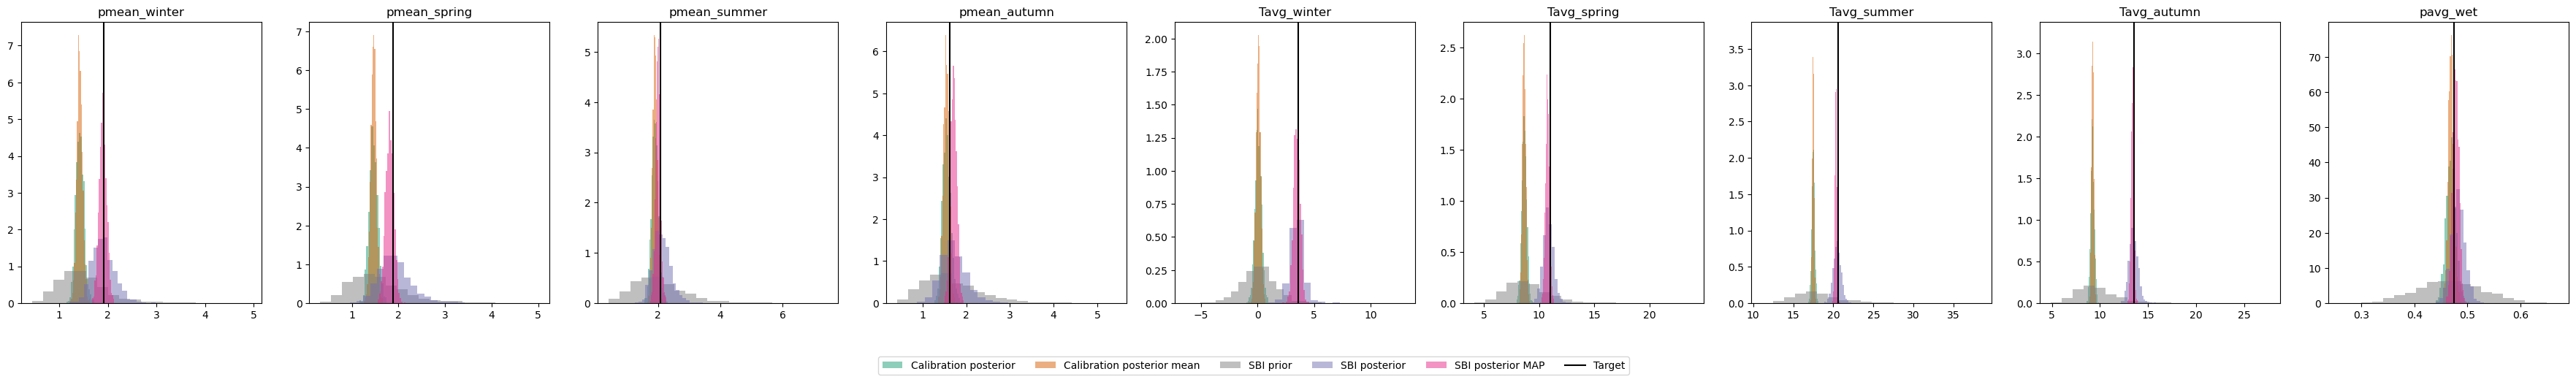

In [52]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3c, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3c.pkl")

## Case study 3d (seasonal Tavg, pr)

In [53]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3d(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn], axis = -1)#, icy_days])

obs_stats = case_study_3d(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.4105059 ,  0.17860313,
        8.4081745 , 17.47531   ,  9.037079  ], dtype=float32)

In [54]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([ 1.9140847,  1.8918679,  2.075413 ,  1.6220818,  3.5786033,
       11.008175 , 20.57531  , 13.537079 ], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 2/2 [00:27<00:00, 13.99s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 2/2 [00:28<00:00, 14.18s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 2/2 [00:28<00:00, 14.14s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/inference/trainers/npe/npe_base.py:177: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:wxsbi

 Neural network successfully converged after 107 epochs.

INFO:wxsbi.wxsbi:Starting round 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

INFO:wxsbi.wxsbi:Starting round 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 95 epochs.

INFO:wxsbi.wxsbi:Starting round 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 25

INFO:wxsbi.wxsbi:Starting round 5/10


 Neural network successfully converged after 26 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 44

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 45 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 40

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 41 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 27

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 28 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 64

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 65 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 30

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 31 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 1000 simulations...
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 2/2 [00:28<00:00, 14.27s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 2/2 [00:28<00:00, 14.13s/it]


6.2543894171714784


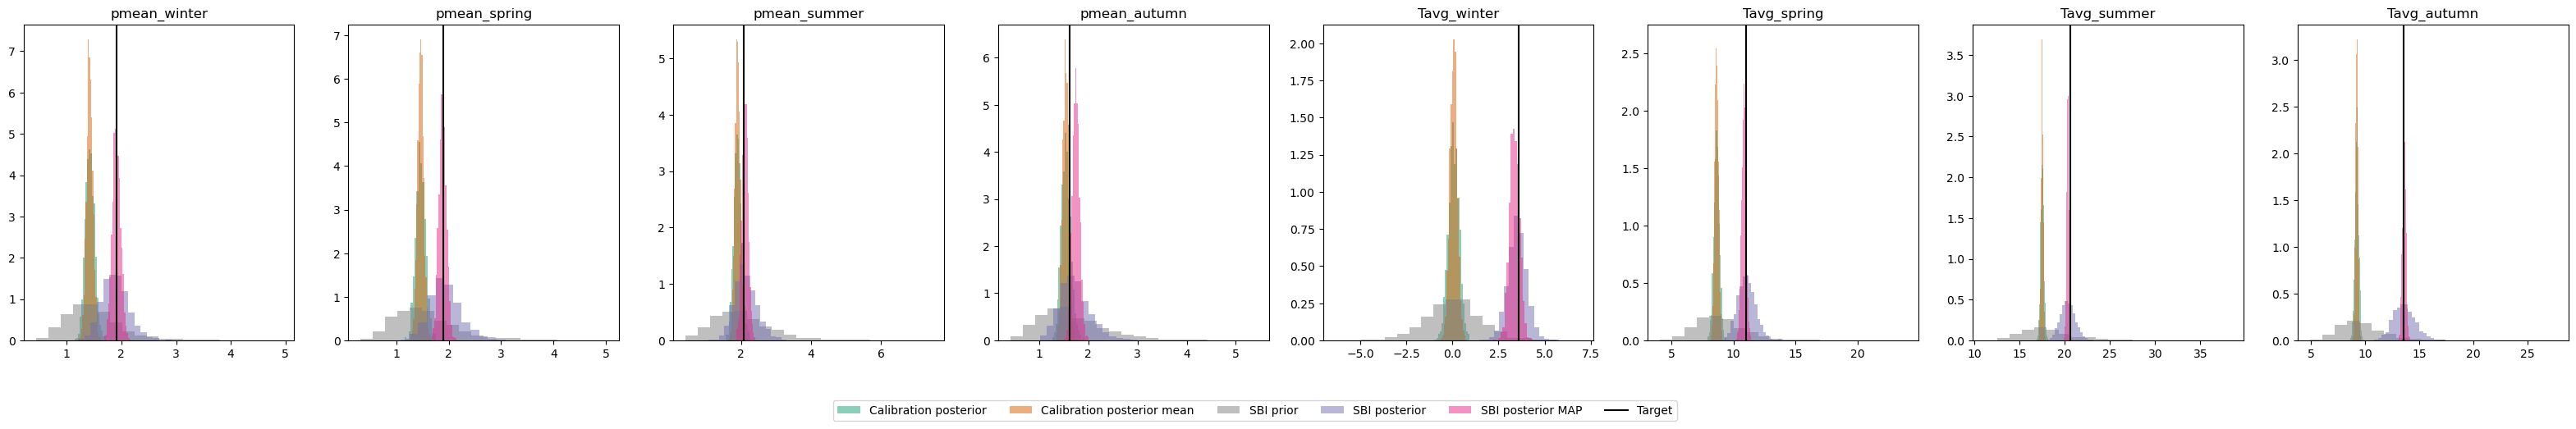

In [55]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3d, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior,
                       calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000,
                       num_rounds = num_rounds, batch_size = batch_size, simulations_per_round = num_simulations_per_round)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3d.pkl")

# Analysis

In [56]:
def make_line_plots(fut, hist, obs, time, target = None, ax = None, color_fut = "lightblue"):
    if ax is None:
        fig, ax = plt.subplots(figsize = (6,4))
        
    df_preds = pd.DataFrame(fut.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = color_fut, alpha = 0.2, ax = ax)
    
    df_preds = pd.DataFrame(hist.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = "grey", alpha = 0.2, ax = ax)
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": calibration_data.index})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].mean().reset_index()
    sns.lineplot(df_obs, x="time", y="obs", color = "black", ax = ax)

    if target is not None:
        ax.axhline(target, color = "darkblue", linestyle = "dashed")

def add_seasonal_targets(targets, ax):
    ax.hlines(y = targets[0], xmin = 1, xmax = 2.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[1], xmin = 2.5, xmax = 5.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[2], xmin = 5.5, xmax = 8.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[3], xmin = 8.5, xmax = 11.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")

def add_monthly_targets(targets, ax):
    for i in range(2, 12):
        ax.hlines(y = targets[i-1], xmin = i-0.5, xmax = i+0.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 1, xmax = 1.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[11], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")


## Case study 1

In [57]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_1a.pkl")

In [58]:
obs_stats_target_1a = result.summary_target

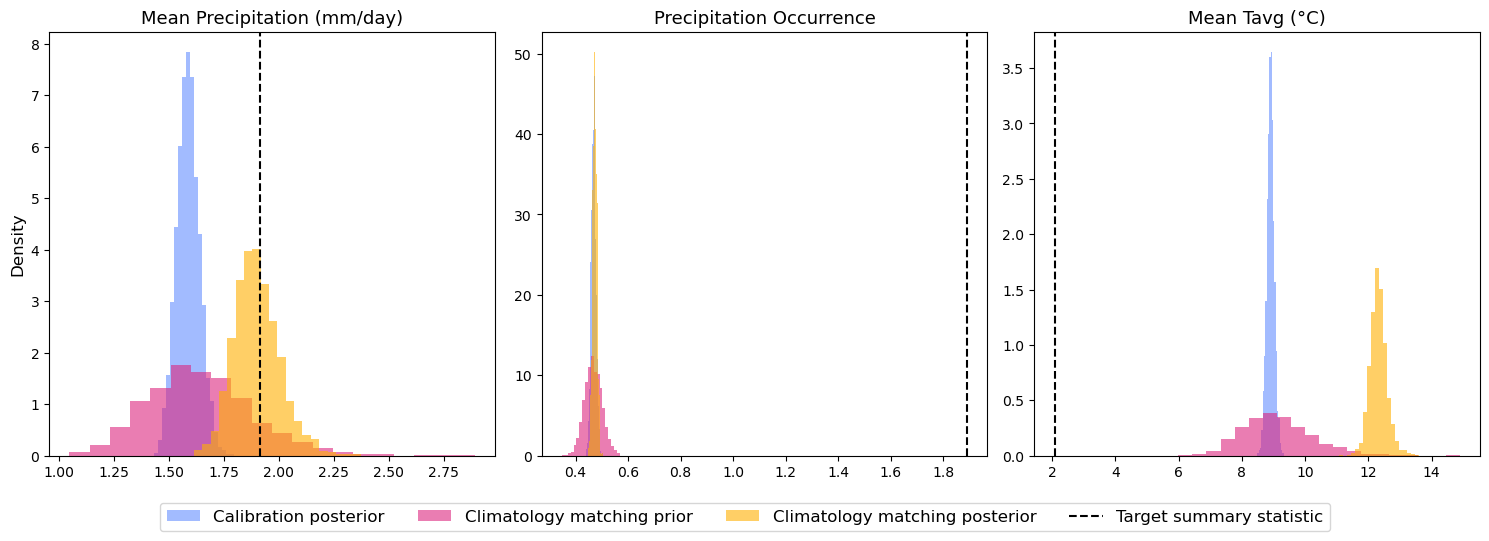

In [59]:
import matplotlib.pyplot as plt

# Colorblind-safe Paul Tol "Bright" palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

# Plot
titles = ["Mean Precipitation (mm/day)", "Precipitation Occurrence", "Mean Tavg (°C)"]

fig, axs = plt.subplots(
    1, obs_stats_target_1a.shape[0],
    figsize=(obs_stats_target_1a.shape[0] * 5, 5),
    layout="tight"
)

for i in range(obs_stats_target_1a.shape[0]):
    axs[i].hist(
        result.simulations["calibration_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["calibration_posterior"],
        label="Calibration posterior"
    )
    axs[i].hist(
        result.simulations["sbi_prior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["sbi_prior"],
        label="Climatology matching prior"
    )
    axs[i].hist(
        result.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["sbi_posterior"],
        label="Climatology matching posterior"
    )

    axs[i].axvline(
        obs_stats_target[i],
        color="black", linestyle="--", linewidth=1.5,
        label="Target summary statistic"
    )

    axs[i].set_title(titles[i], fontsize=13)
    #axs[i].grid(alpha=0.3)

#axs[0].set_xlabel("Mean Precipitation (mm/day)", fontsize=12)
#axs[1].set_xlabel("Precipitation Occurrence", fontsize=12)
#axs[2].set_xlabel("Mean Tavg (°C)", fontsize=12)
axs[0].set_ylabel("Density", fontsize=12)
#axs[1].set_ylabel("Density", fontsize=12)
#axs[2].set_ylabel("Density", fontsize=12)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Shared legend below the plots, with box
fig.legend(
    by_label.values(), by_label.keys(),
    loc="upper center", bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=False, ncol=4, frameon=True,
    fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_1.png", dpi=300, bbox_inches="tight")
plt.show()

In [60]:
ts = result.simulate_ts('sbi_posterior_map', 'calibration_posterior_mean', observables = ['prec', 'Tavg'], num_samples=10, from_parameter_samples = False)

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 10 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 10 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 10 simulations from calibration posterior


In [61]:
obs_hist = ts["calibration_posterior_mean"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

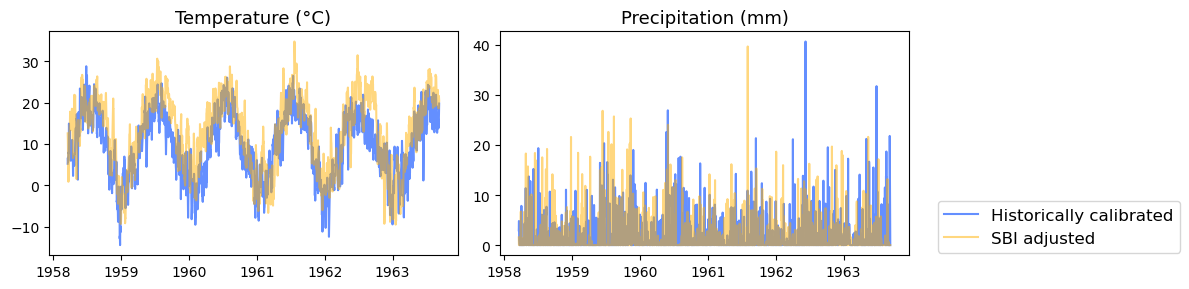

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 3), layout = "tight")

ax1.plot(calibration_data.index[3000:5000], tavg_hist[0, 3000:5000], label = "Historically calibrated", color = '#648FFF')
ax1.plot(calibration_data.index[3000:5000], tavg_fut[1, 3000:5000], alpha = 0.5, label = "SBI adjusted", color = '#FFB000')
ax1.set_title("Temperature (°C)", fontsize = 13)

ax2.plot(calibration_data.index[3000:5000], pr_hist[0, 3000:5000], label = "Historically calibrated", color = '#648FFF')
ax2.plot(calibration_data.index[3000:5000], pr_fut[1, 3000:5000], alpha = 0.5, label = "SBI adjusted", color = '#FFB000')
ax2.legend(bbox_to_anchor = (1.05, 0.28), fontsize = 12)
ax2.set_title("Precipitation (mm)", fontsize = 13)

plt.savefig("plots/analysis_v2/case_study_1_temp_precip.png")

### Simulation-based calibration

In [63]:
from sbi.diagnostics import run_sbc, check_sbc
from sbi.analysis.plot import sbc_rank_plot
from wxsbi.utils import j2t

In [64]:
theta_prior, x_prior = result.simulate_from_sbi_prior(num_samples=300)
(theta_post, x_post), _ = result.simulate_from_sbi_posterior(num_samples=300)

INFO:wxsbi.wxsbi:Running 300 simulations for SBI prior


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 300 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 300 simulations for SBI posterior MAP estimate


In [65]:
thetas = theta_post
xs = x_post

In [66]:
ranks_all, dap_samples_all = run_sbc(j2t(thetas), j2t(xs), result.sbi_posterior)

/home/briangr/miniforge3/envs/wxsbi/lib/python3.13/site-packages/sbi/utils/diagnostics_utils.py:45: UserWarning: Capping max_sampling_batch_size from 10000 to 333 to avoid excessive memory usage.
  posterior_samples = posterior.sample_batched(


Drawing 1000 samples for 300 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 300 SBC samples:   0%|          | 0/300 [00:00<?, ?it/s]

In [67]:
ranks_lp, dap_samples_lp = run_sbc(j2t(thetas), j2t(xs), result.sbi_posterior, reduce_fns=result.sbi_posterior.log_prob)

Drawing 1000 samples for 300 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 300 SBC samples:   0%|          | 0/300 [00:00<?, ?it/s]

In [68]:
dap_samples_lp.shape

torch.Size([300, 126])

In [69]:
check_stats_all = check_sbc(ranks_all, j2t(thetas), dap_samples_all, num_posterior_samples=1000)
check_stats_all

{'ks_pvals': tensor([0.3060, 0.5435, 0.6202, 0.0013, 0.0162, 0.2861, 0.3559, 0.0125, 0.2797,
         0.5435, 0.9321, 0.3947, 0.0130, 0.9561, 0.6494, 0.1293, 0.2734, 0.3267,
         0.0690, 0.4444, 0.5156, 0.1066, 0.0156, 0.1726, 0.4530, 0.7917, 0.4794,
         0.5911, 0.6883, 0.5719, 0.9473, 0.1910, 0.0541, 0.0097, 0.4530, 0.0558,
         0.4973, 0.4109, 0.7644, 0.2734, 0.4191, 0.8590, 0.5435, 0.1096, 0.8266,
         0.5341, 0.1771, 0.9321, 0.3559, 0.1364, 0.8006, 0.1439, 0.4883, 0.3411,
         0.3128, 0.2434, 0.8006, 0.4883, 0.2057, 0.0448, 0.6980, 0.2057, 0.1517,
         0.0849, 0.1224, 0.9602, 0.6202, 0.2007, 0.1958, 0.2926, 0.6396, 0.9266,
         0.0345, 0.4883, 0.0611, 0.1364, 0.6494, 0.7644, 0.0230, 0.4191, 0.6980,
         0.5719, 0.2434, 0.3947, 0.2672, 0.2861, 0.8266, 0.6980, 0.9561, 0.9149,
         0.1439, 0.8667, 0.0980, 0.6299, 0.2108, 0.5529, 0.7736, 0.6008, 0.1958,
         0.7268, 0.7551, 0.6980, 0.4191, 0.7827, 0.9842, 0.2926, 0.4617, 0.0063,
         0.0899,

In [70]:
check_stats_lp = check_sbc(ranks_lp, j2t(thetas), dap_samples_lp, num_posterior_samples=1000)
check_stats_lp

{'ks_pvals': tensor([0.0302]),
 'c2st_ranks': tensor([0.4767], dtype=torch.float64),
 'c2st_dap': tensor([0.5350, 0.5150, 0.5017, 0.5283, 0.4717, 0.5150, 0.4900, 0.5317, 0.4650,
         0.5100, 0.4917, 0.5083, 0.4733, 0.4950, 0.5017, 0.4767, 0.4767, 0.5133,
         0.5050, 0.5167, 0.5267, 0.5017, 0.4900, 0.5067, 0.4633, 0.4950, 0.5033,
         0.5567, 0.4717, 0.4783, 0.5000, 0.4883, 0.5067, 0.5183, 0.5367, 0.5200,
         0.5317, 0.5000, 0.5350, 0.4633, 0.5083, 0.4833, 0.4883, 0.5350, 0.5017,
         0.5283, 0.4750, 0.5050, 0.4767, 0.5383, 0.5367, 0.4883, 0.4900, 0.4883,
         0.5417, 0.4350, 0.4917, 0.4950, 0.5500, 0.4850, 0.5300, 0.5483, 0.5000,
         0.5100, 0.5017, 0.5067, 0.4733, 0.5217, 0.5483, 0.5300, 0.4883, 0.4433,
         0.5683, 0.4933, 0.4717, 0.4550, 0.5067, 0.5083, 0.4783, 0.4783, 0.5217,
         0.5517, 0.5167, 0.4817, 0.4817, 0.4883, 0.4983, 0.4883, 0.4667, 0.5067,
         0.4817, 0.4917, 0.5133, 0.4850, 0.4717, 0.5033, 0.4967, 0.5083, 0.5050,
         0.5

(array([11.,  8., 10.,  7.,  7.,  8.,  4.,  3.,  6.,  8.,  5.,  7.,  7.,
         6.,  5.,  5.,  6.,  3.,  5.,  5.]),
 array([0.00134642, 0.05048848, 0.09963055, 0.14877261, 0.19791467,
        0.24705674, 0.29619882, 0.34534088, 0.39448294, 0.443625  ,
        0.49276707, 0.54190916, 0.59105122, 0.64019328, 0.68933535,
        0.73847741, 0.78761947, 0.83676153, 0.8859036 , 0.93504566,
        0.98418772]),
 <BarContainer object of 20 artists>)

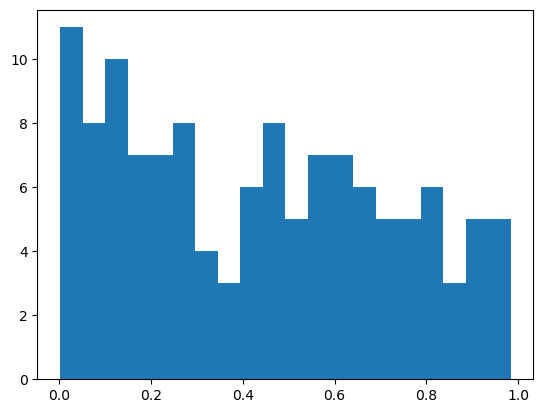

In [71]:
plt.hist(check_stats_all['ks_pvals'], bins=20)

In [72]:
# Calculate rejection rate of FDR of marginal KS tests under arbitrary dependence and Euler-Mascheroni constant = 0.57721
pvals_sorted, _ = check_stats_all['ks_pvals'].sort()
(pvals_sorted.cumsum(dim=0) < wxsbi.torch.arange(1, 127) / (126*(np.log(126) + 0.57721 + 1 / (2*126))) * 0.05).sum() / 126

tensor(0.)

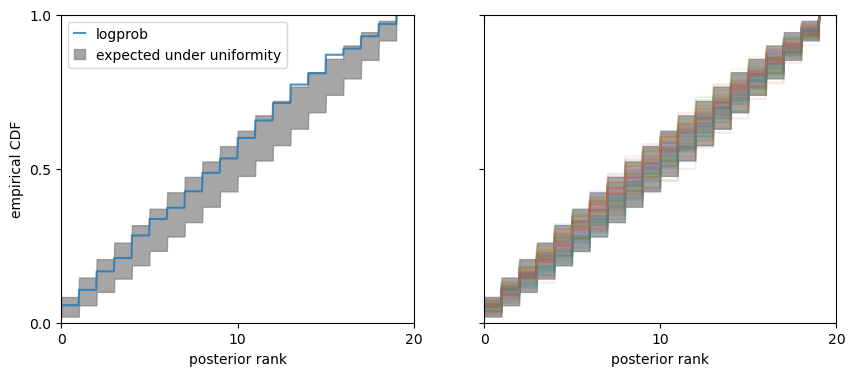

In [73]:
# create two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# draw each plot into the corresponding axes (if the function accepts ax=)
sbc_rank_plot(ranks_all, 1000, fig=fig, ax=axs[1], num_bins=20, uniform_region_alpha=0.7, line_alpha=0.1)
sbc_rank_plot(ranks_lp,  1000, fig=fig, ax=axs[0], parameter_labels=["logprob"], num_bins=20, uniform_region_alpha=0.7)
axs[1].get_legend().set_visible(False)
axs[1].set_ylabel("")
plt.savefig("plots/analysis_v2/sbc_case_study_1a_posterior_n=1.png", dpi=300)

In [74]:
hist_all = wxsbi.torch.stack([wxsbi.torch.histogram(ranks_all[:,i], 20)[0] for i in range(ranks_all.shape[1])], dim=1)
ecdf_all = hist_all.cumsum(dim=0)
ecdf_all = ecdf_all / ecdf_all.max(dim=0, keepdim=True)[0]
ecdf_all.shape

torch.Size([20, 126])

In [75]:
wgen_dist = wgen.as_distribution()
dummy_sample = wgen_dist.sample()*0

In [76]:
# get sorted list of parameters at midpoint of CDF
dummy_sample = dummy_sample.at[ecdf_all[10,:].argmax().item()].set(1)
wgen_dist.constrain(dummy_sample, as_dict=True)

OrderedDict([('Tavg_loc_lag', Array([-0., -0.], dtype=float32)),
             ('Tavg_loc_seasonal', Array([-0., -0., -0.,  0.], dtype=float32)),
             ('Tavg_loc_seasonal_lag_interaction',
              Array([-0.,  0.,  0.,  0., -0., -0., -0.,  0.], dtype=float32)),
             ('Tavg_loc_pred', Array([-0.], dtype=float32)),
             ('Tavg_loc_scale_seasonal',
              Array([-0.,  0., -0., -0.], dtype=float32)),
             ('Tavg_loc_scale_pred', Array([-0.], dtype=float32)),
             ('precip_occ_seasonal',
              Array([-0., -0.,  1., -0.], dtype=float32)),
             ('precip_occ_lag', Array([-0.,  0.,  0.,  0.], dtype=float32)),
             ('precip_occ_lag_seasonal_interaction',
              Array([-0., -0.,  0., -0.,  0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,
                      0., -0.,  0.], dtype=float32)),
             ('precip_occ_Tavg', Array([-0.], dtype=float32)),
             ('precip_occ_Tavg_seasonal_interaction',
              

### Prior consistency checks

In [77]:
obs_stats_1a = case_study_1a(**obs)

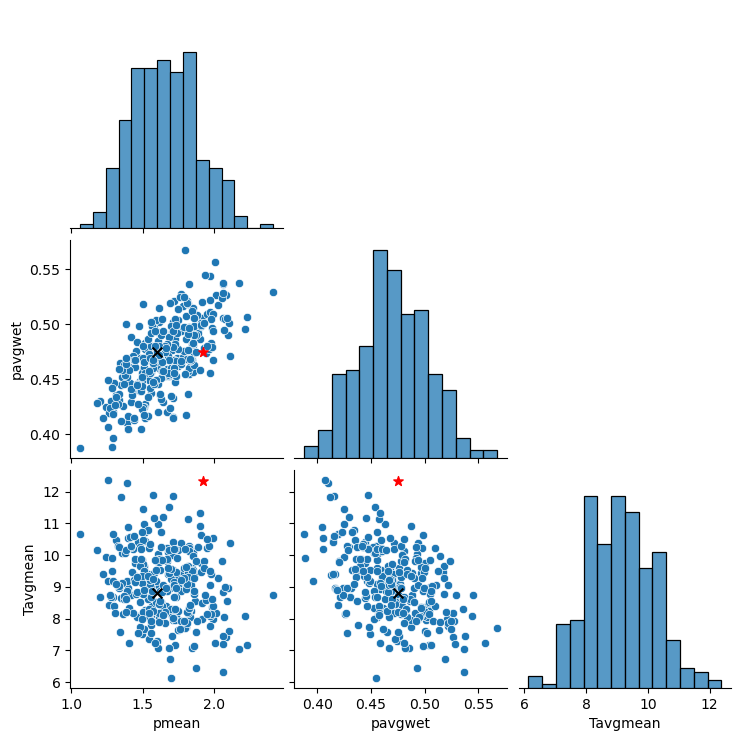

In [78]:
df_prior = pd.DataFrame(x_prior, columns=case_study_1a.names)
grid = sns.pairplot(df_prior, corner=True)
for i in range(len(obs_stats_1a)):
    for j in range(i+1, len(obs_stats_1a)):
        grid.axes[j, i].scatter(obs_stats_1a[i], obs_stats_1a[j], color="black", marker="x", s=50.0, zorder=10)
        grid.axes[j, i].scatter(obs_stats_target_1a[i], obs_stats_target_1a[j], color="red", marker="*", s=50.0, zorder=10)

## Case study 2

In [79]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_2.pkl")

In [80]:
obs_stats_2 = case_study_2(**obs)
obs_stats_target_2 = result.summary_target

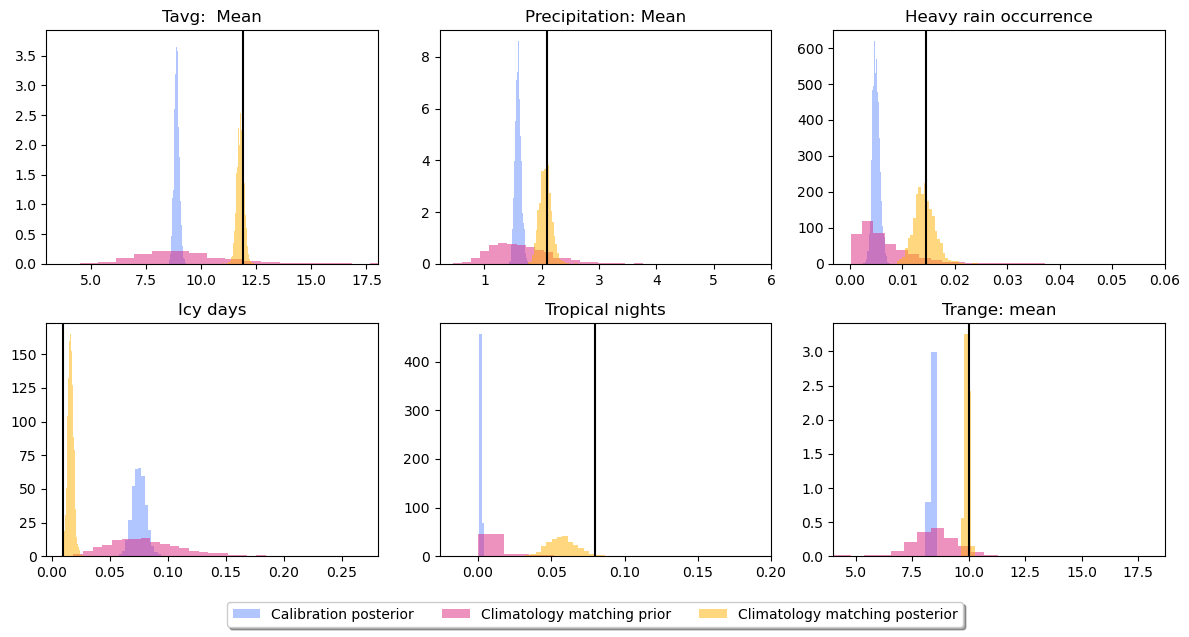

In [81]:
# Plot
colours = ["#648FFF", "#DC267F", "#FFB000"]

titles = ["Tavg:  Mean", "Precipitation: Mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange: mean"]
left_xlims = [3, None, None, None, None, 4]
right_xlims = [18, 6, 0.06, None, 0.2, None]

fig, axs = plt.subplots(2, 3, figsize = (12, 6), layout = "tight")
axs = axs.ravel()
for i in range(obs_stats_target_2.shape[0]):
    axs[i].hist(result.simulations["calibration_posterior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Calibration posterior", color = colours[0])
    axs[i].hist(result.simulations["sbi_prior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior", color = colours[1])
    axs[i].hist(result.simulations["sbi_posterior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Climatology matching posterior", color = colours[2])
    #axs[i].legend(loc = "upper right")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target_2[i].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v2/case_study_2.png", dpi = 300, bbox_inches='tight')


### Prior consistency checks

In [82]:
theta_prior, x_prior = result.simulate_from_sbi_prior(num_samples=300)
(theta_post, x_post), _ = result.simulate_from_sbi_posterior(num_samples=300)

INFO:wxsbi.wxsbi:Running 300 simulations for SBI prior


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 300 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 300 simulations for SBI posterior MAP estimate


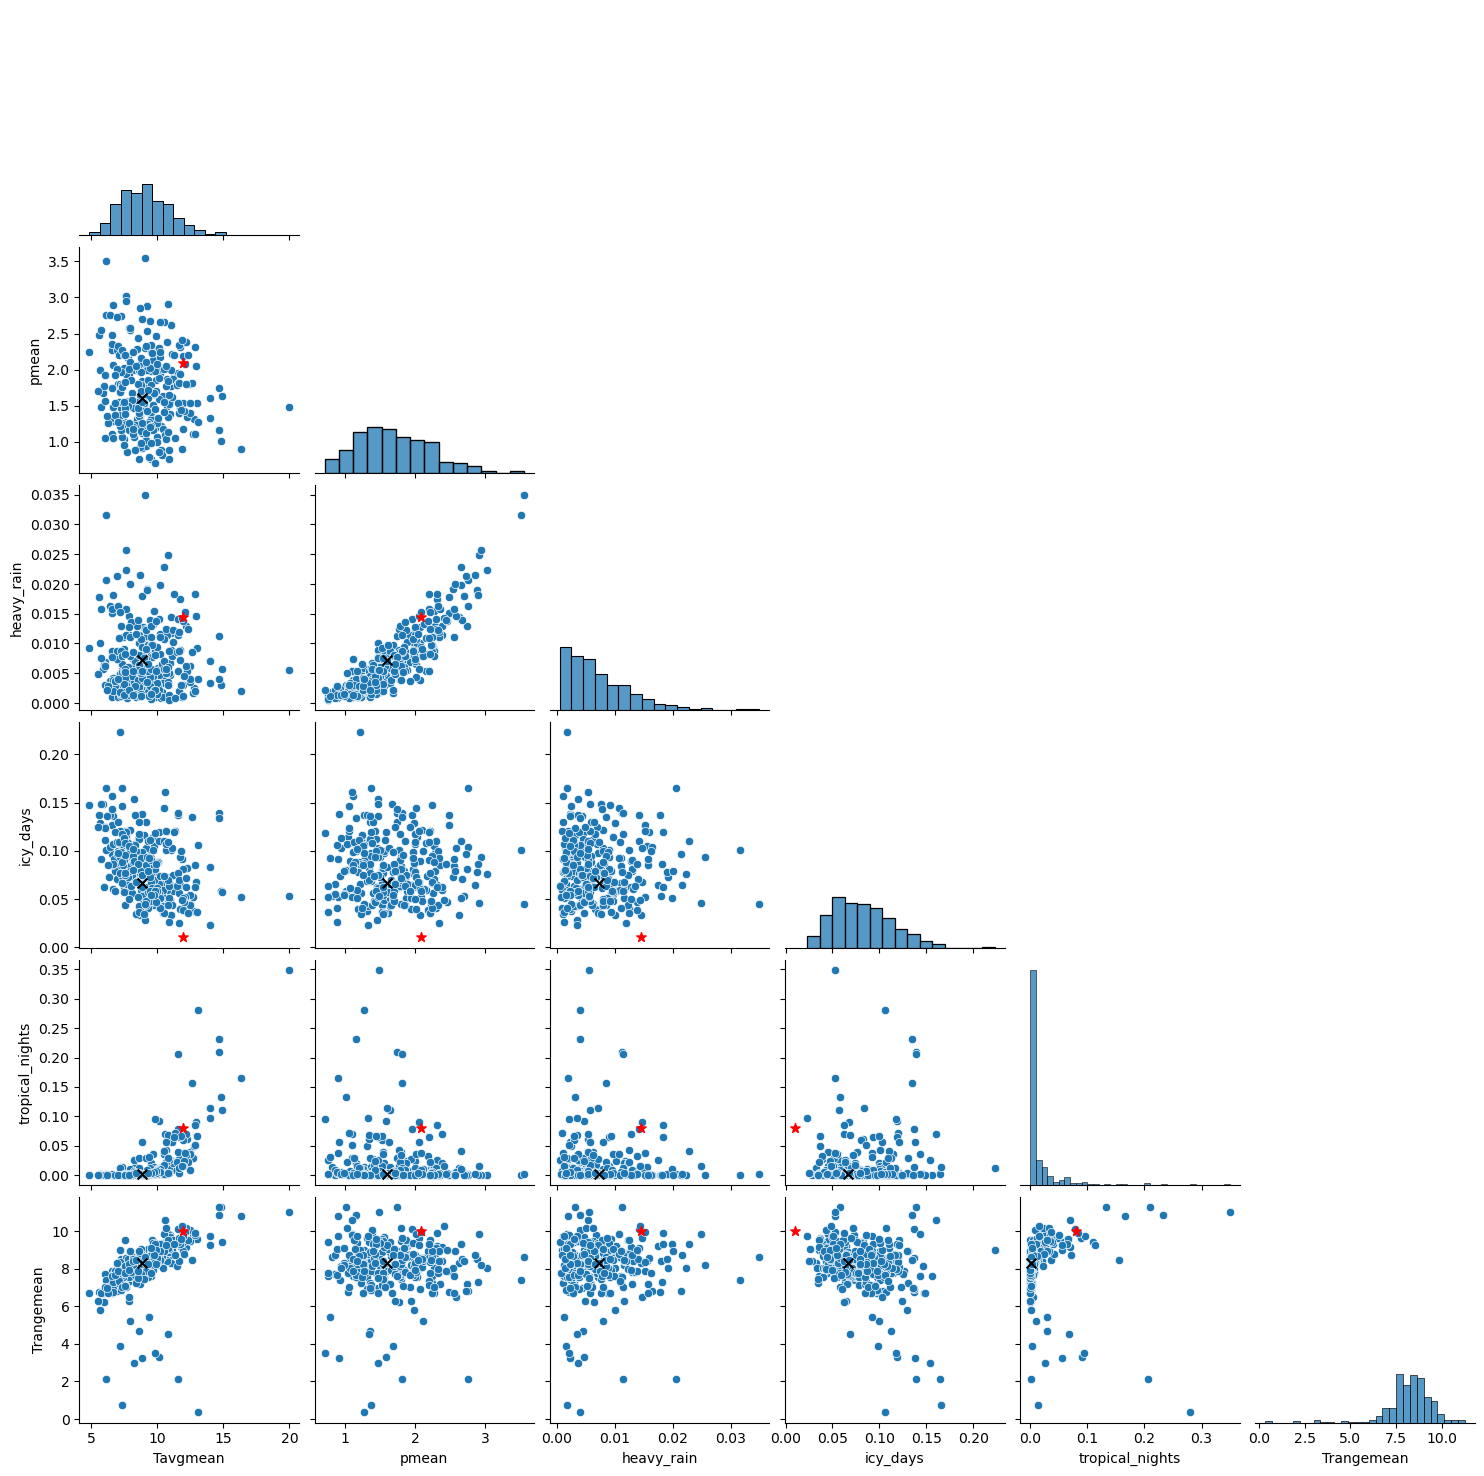

In [83]:
df_prior_2 = pd.DataFrame(x_prior, columns=case_study_2.names)
grid = sns.pairplot(df_prior_2, corner=True)
for i in range(len(obs_stats_2)):
    for j in range(i+1, len(obs_stats_2)):
        grid.axes[j, i].scatter(obs_stats_2[i], obs_stats_2[j], color="black", marker="x", s=50.0, zorder=10)
        grid.axes[j, i].scatter(obs_stats_target_2[i], obs_stats_target_2[j], color="red", marker="*", s=50.0, zorder=10)

In [84]:
grid.axes[2,2]

<Axes: >

## Case study 3

### Overview part a)

In [85]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_3a.pkl")
obs_stats_target = result.summary_target


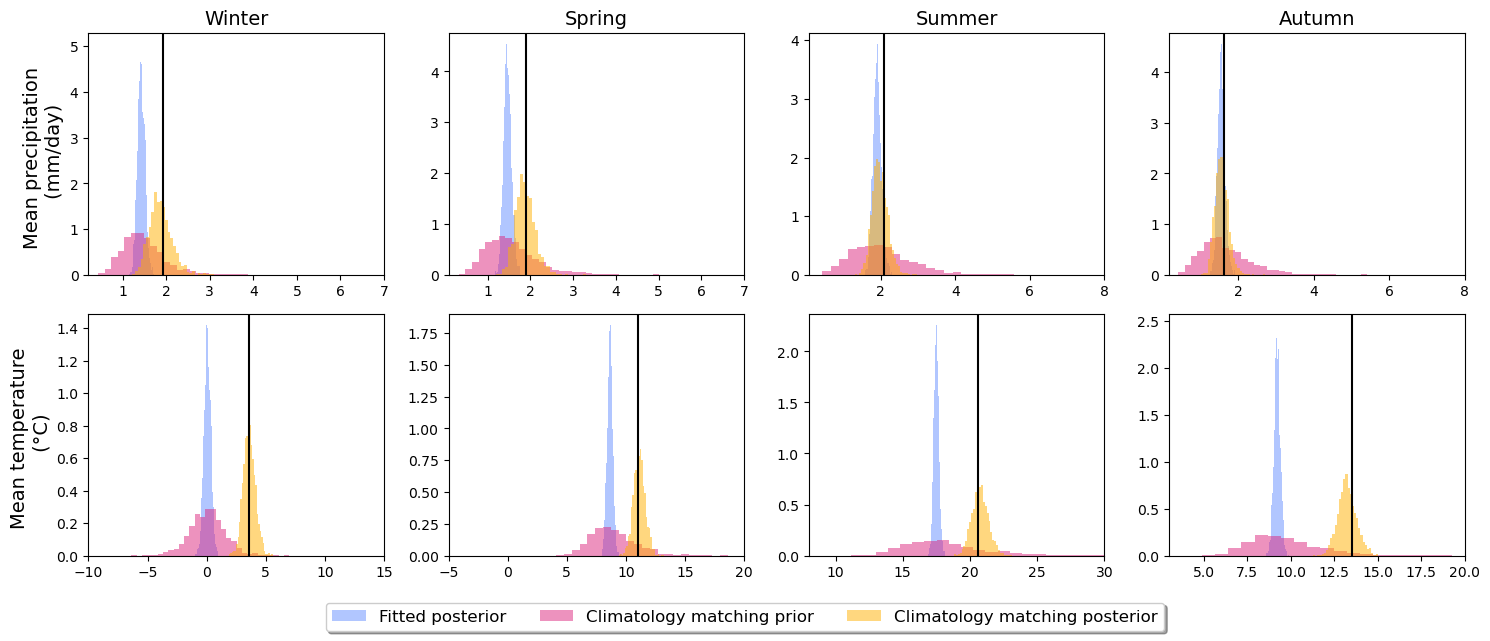

In [86]:
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3a.png", dpi=300, bbox_inches='tight')

In [87]:
ts = result.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


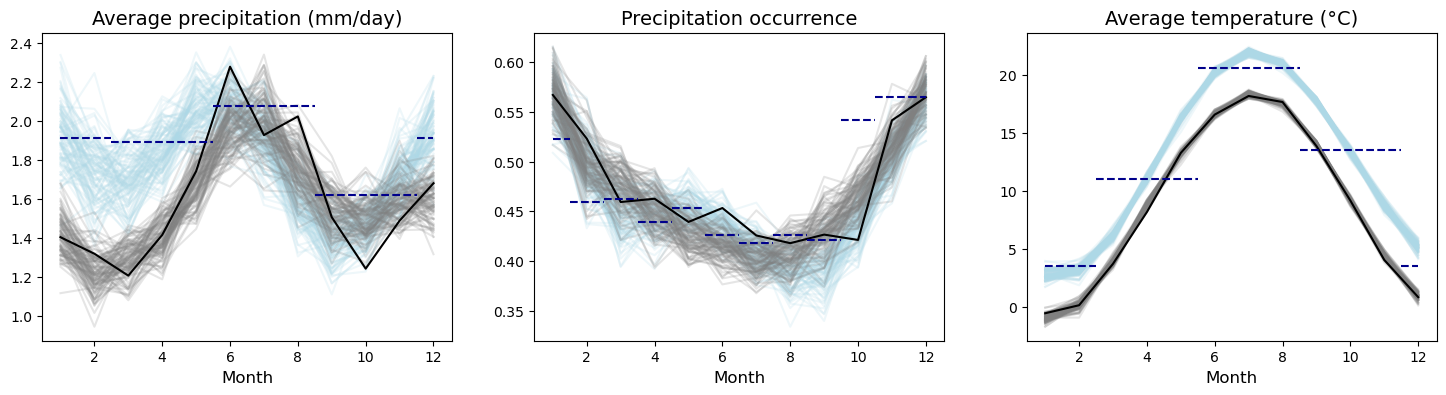

In [88]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[1])
add_monthly_targets(obs_stats_target[9:], axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:9], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3a_ensemble.png", dpi=300, bbox_inches='tight')

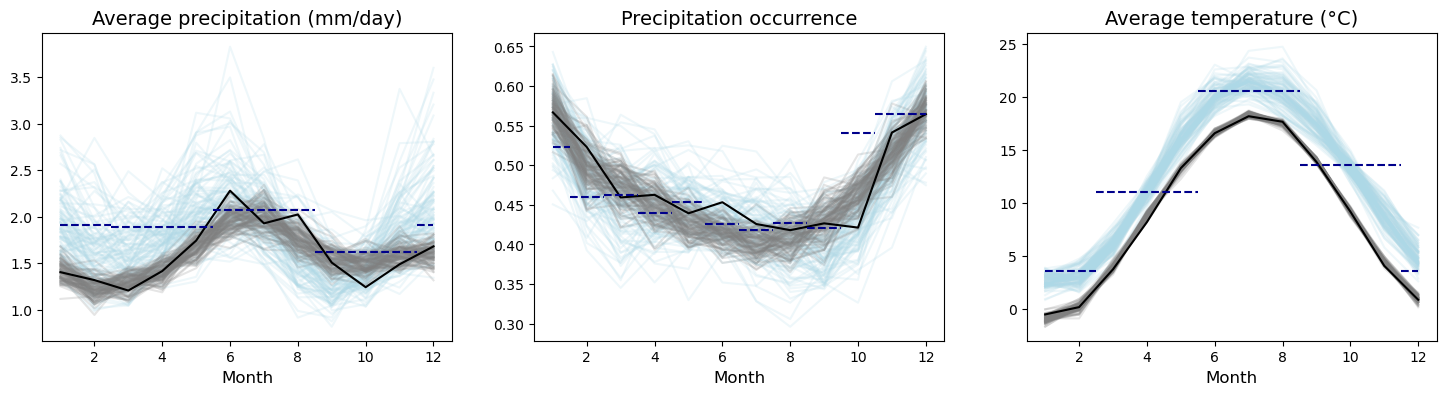

In [89]:
obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[1])
add_monthly_targets(obs_stats_target[9:], axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:9], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3a_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

### Overview part b)

In [90]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_3b.pkl")
obs_stats_target = result.summary_target


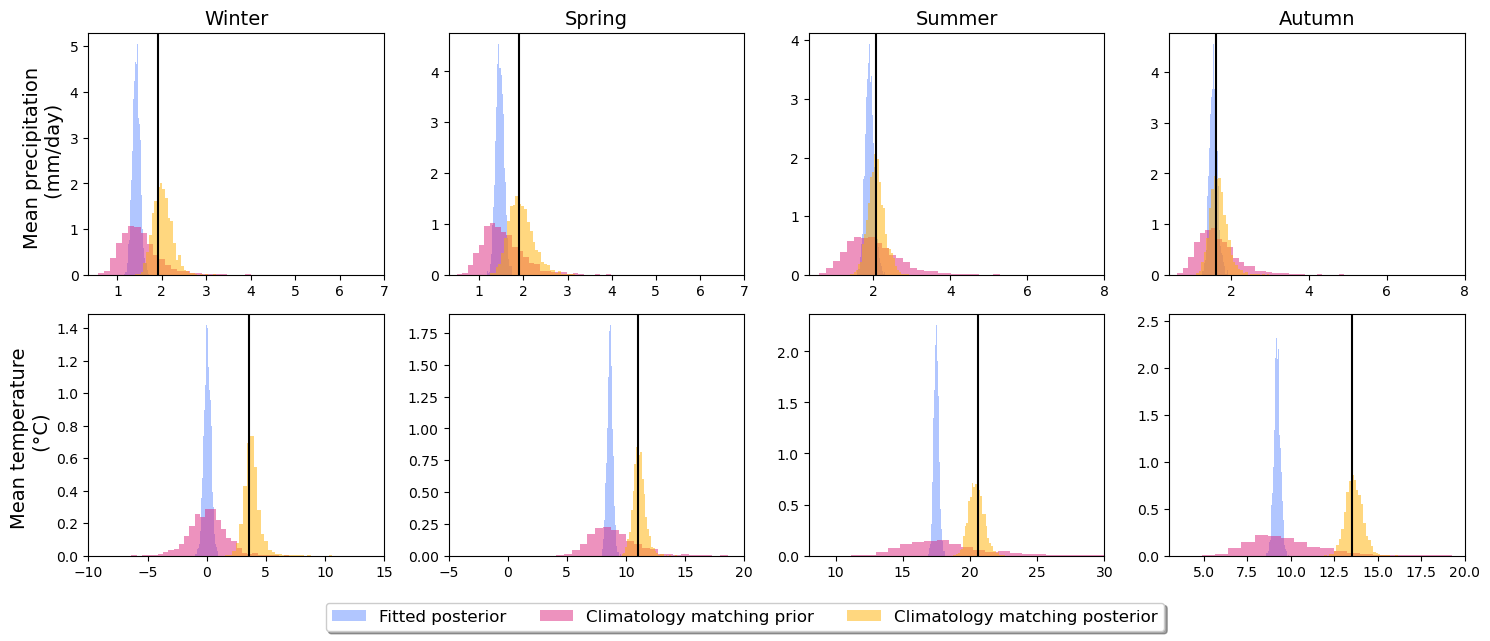

In [91]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3b.png", dpi=300, bbox_inches='tight')

In [92]:
ts = result.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


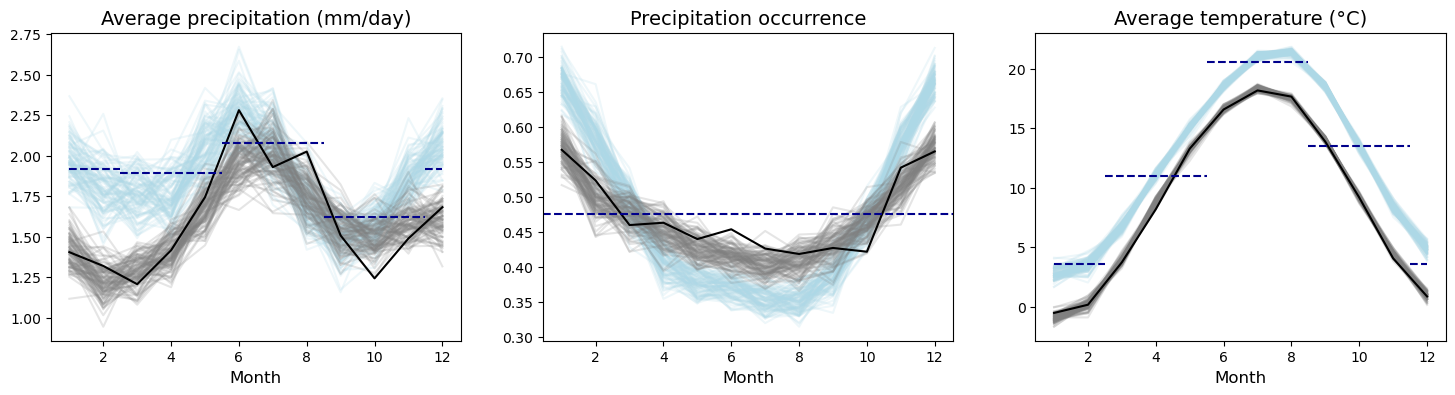

In [93]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[1], target = obs_stats_target[-1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3b_ensemble.png", dpi=300, bbox_inches='tight')

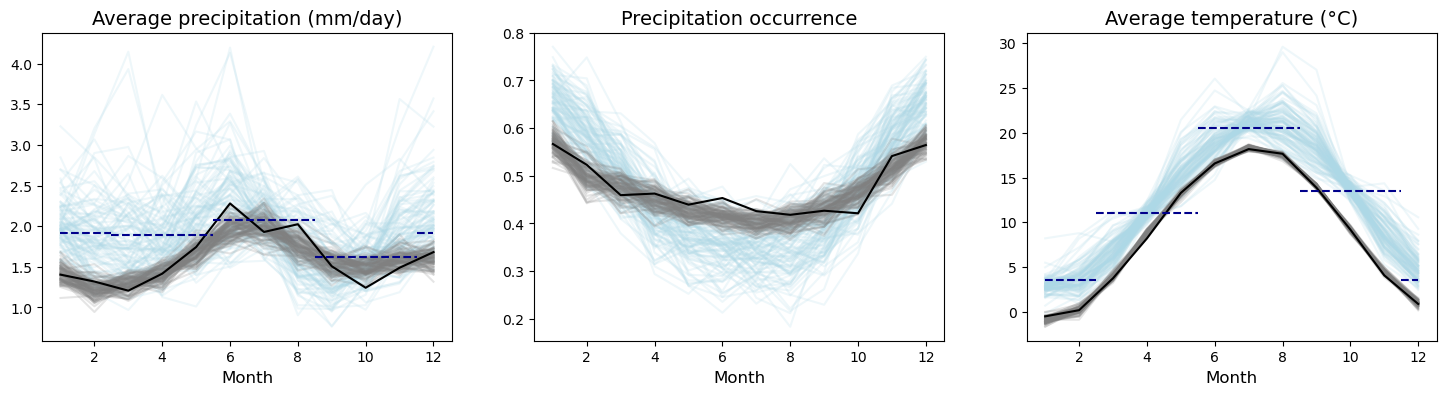

In [94]:
obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3b_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

### Overview part c)

In [95]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_3c.pkl")
obs_stats_target = result.summary_target


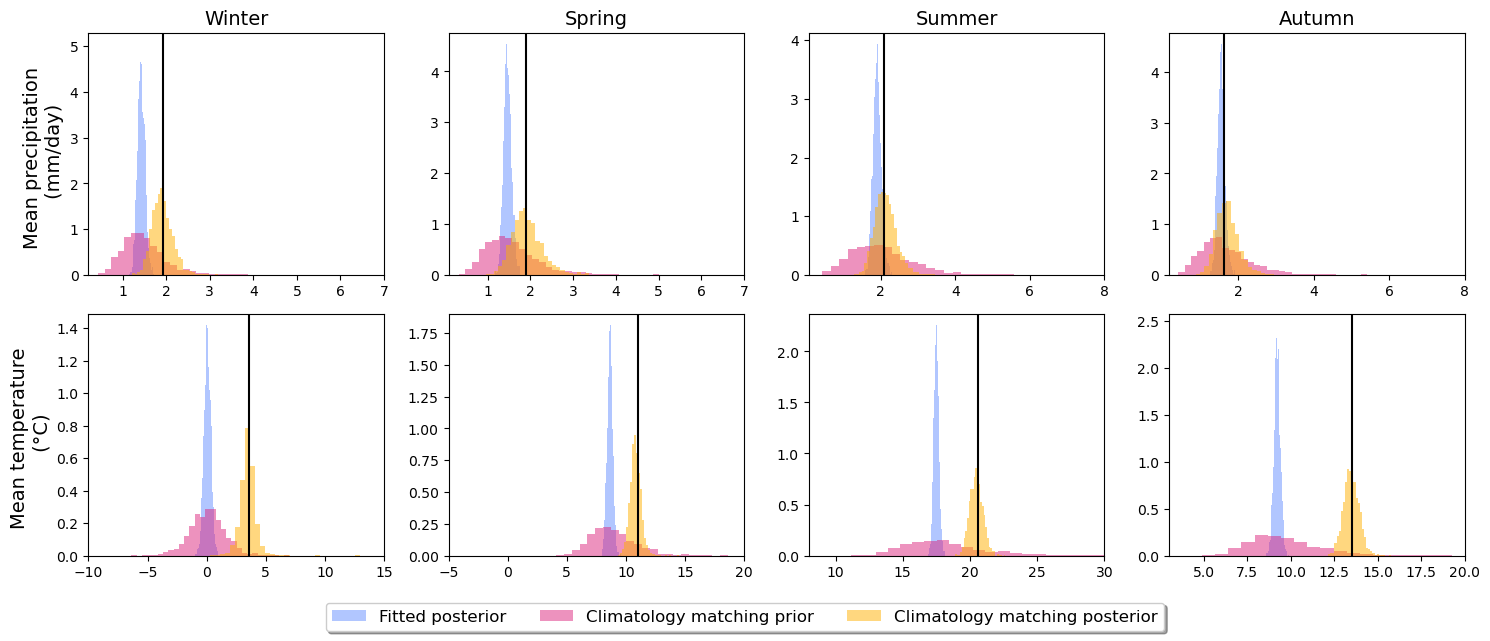

In [96]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3c.png", dpi=300, bbox_inches='tight')

In [97]:
ts = result.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


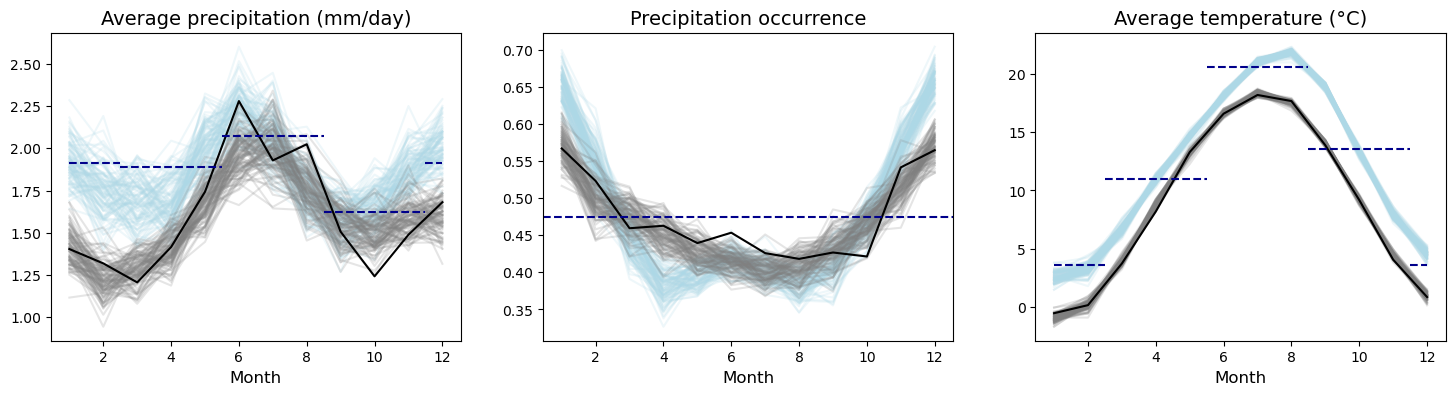

In [98]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[1], target = obs_stats_target[9])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3c_ensemble.png", dpi=300, bbox_inches='tight')

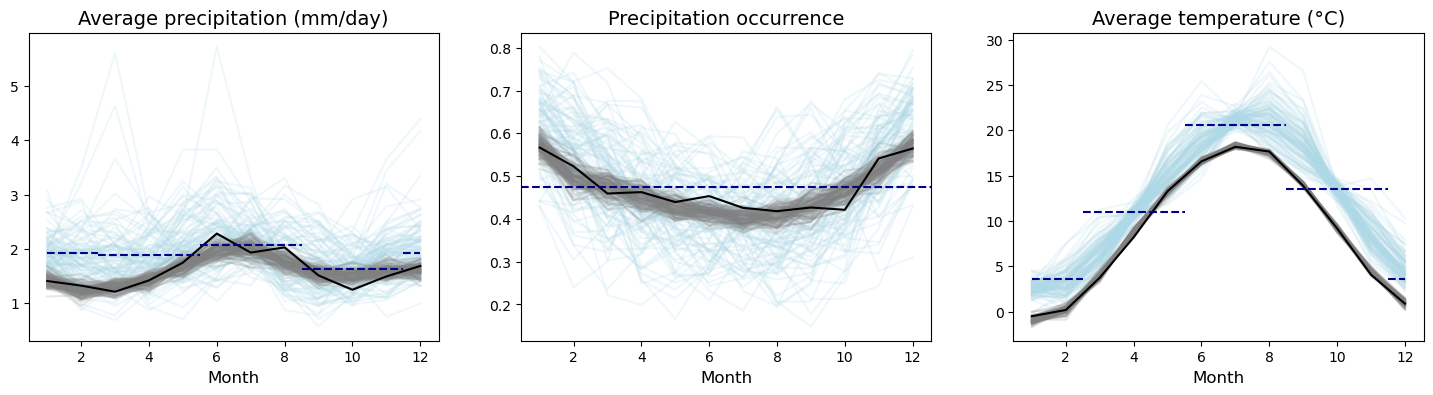

In [99]:
obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[1], target = obs_stats_target[9])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3c_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

### Overview part d)

In [100]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_3d.pkl")
obs_stats_target = result.summary_target


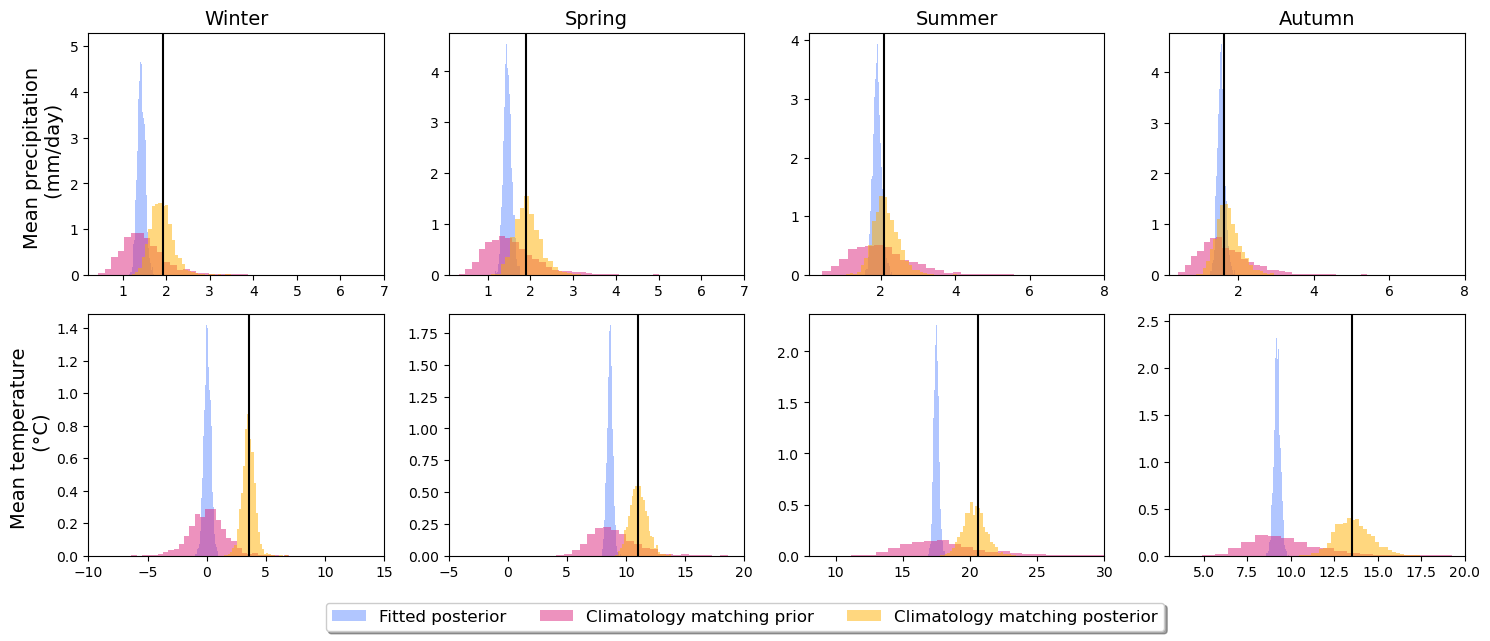

In [101]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3d.png", dpi=300, bbox_inches='tight')

In [102]:
ts = result.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


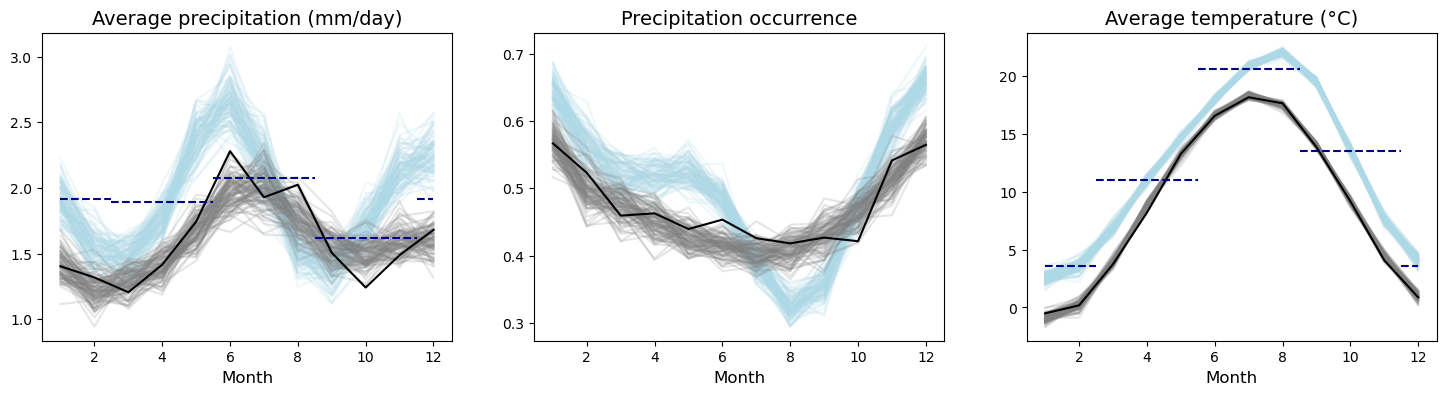

In [103]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3d_ensemble.png", dpi=300, bbox_inches='tight')

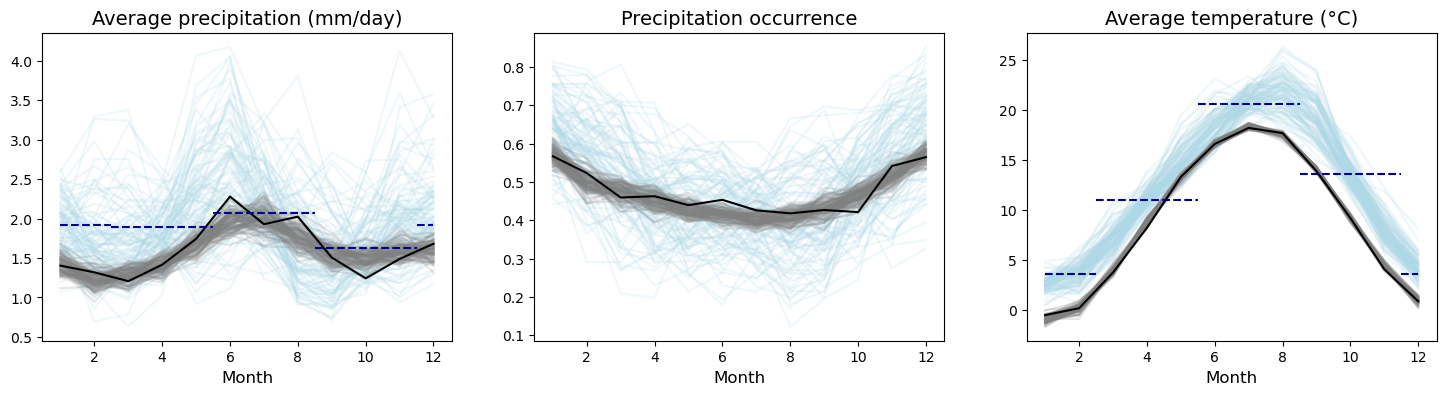

In [104]:
obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], calibration_data.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], calibration_data.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3d_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

### Comparison of Climatology matching posterior for occurrence

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


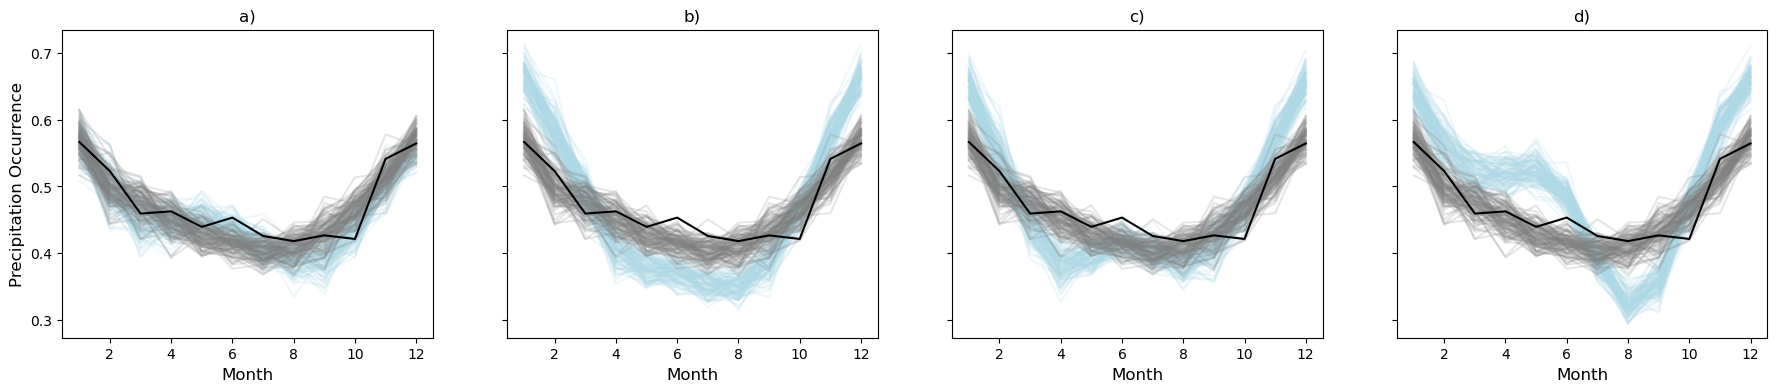

In [105]:
case_studies = ["3a", "3b", "3c", "3d"]
case_study_names = ["a)", "b)", "c)", "d)"]

fig, axs = plt.subplots(1,4, figsize = (22,4), sharey = True)

for i in range(4):

    case_study = case_studies[i]
    case_study_name = case_study_names[i]

    result = wxsbi.SBIResults.from_file(f"sbi_results/case_study_{case_study}.pkl")
    ts = result.simulate_ts('sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
    
    obs_hist = ts["calibration_posterior"]
    obs_fut = ts["sbi_posterior_map"]

    pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
    pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[i])
    axs[i].set_title(case_study_name)
    axs[i].set_xlabel("Month", fontsize = 12)

axs[0].set_ylabel("Precipitation Occurrence", fontsize = 12)


    #fig.suptitle("Precipitation occurrence")

plt.savefig("plots/analysis_v2/case_study_3_occ_comparison.png", dpi=300, bbox_inches='tight')

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 100 simulations for SBI posterior MAP estimate
INFO:wxsbi.wxsbi:Running 100 simulations from calibration posterior


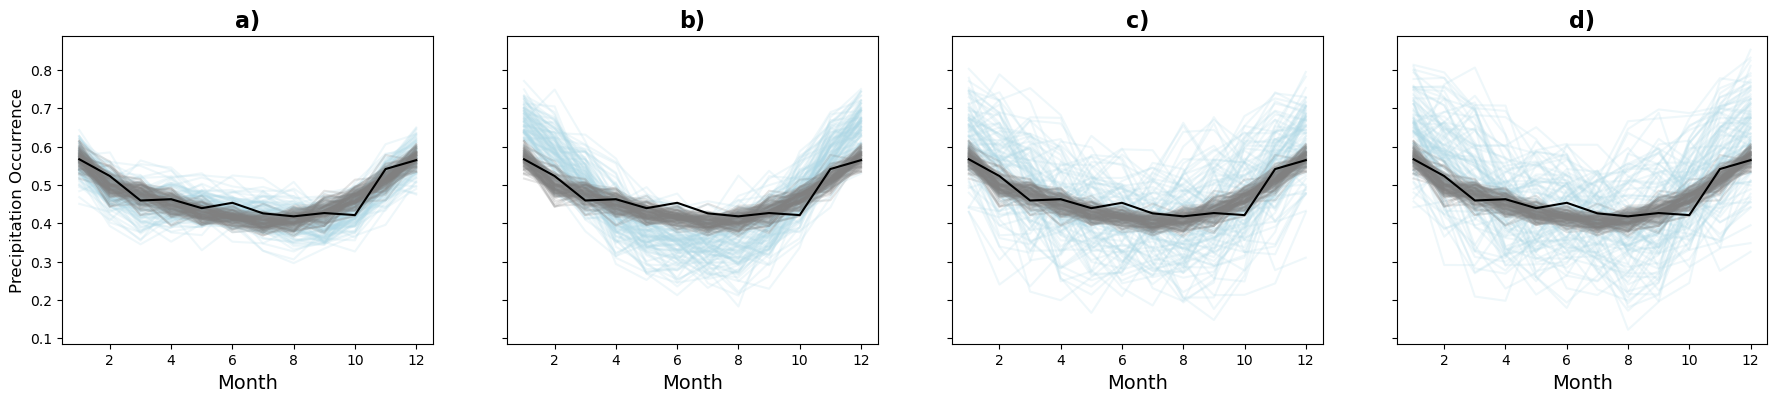

In [106]:
case_studies = ["3a", "3b", "3c", "3d"]
case_study_names = ["a)", "b)", "c)", "d)"]

fig, axs = plt.subplots(1,4, figsize = (22,4), sharey = True)

for i in range(4):

    case_study = case_studies[i]
    case_study_name = case_study_names[i]

    result = wxsbi.SBIResults.from_file(f"sbi_results/case_study_{case_study}.pkl")
    ts = result.simulate_ts('sbi_posterior', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
    
    obs_hist = ts["calibration_posterior"]
    obs_fut = ts["sbi_posterior"]

    pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
    pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, calibration_data.index, ax = axs[i])
    axs[i].set_title(case_study_name, fontsize=16, fontweight="bold")
    axs[i].set_xlabel("Month", fontsize = 14)
axs[0].set_ylabel("Precipitation Occurrence", fontsize = 12)

    #fig.suptitle("Precipitation occurrence")

plt.savefig("plots/analysis_v2/case_study_3_occ_comparison_full_posterior.png", dpi=300, bbox_inches='tight')

## Model/target misspecification

## Amortization Case study 1

In [107]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_1a.pkl")

Original: *1.2, +3.5
Case 1: *1.15, +3.0
Case 2: *1.25, +4.0

In [108]:
@wxsbi.summarystats("pmean", "pavgwet", "Tavgmean")
def case_study_1a(prec, Tavg, **kwargs):
    pmean = jnp.mean(prec, axis = -1)
    pavgwet = jnp.mean(prec > 0, axis = -1)
    Tavgmean = jnp.mean(Tavg, axis = -1)
    return jnp.stack([pmean, pavgwet, Tavgmean], axis = -1)
obs_stats = case_study_1a(**obs).flatten()

In [109]:
obs_stats_target1 = obs_stats
obs_stats_target1 = obs_stats_target1.at[0].mul(1.3)
obs_stats_target1 = obs_stats_target1.at[2].add(3.0)

obs_stats_target2 = obs_stats
obs_stats_target2 = obs_stats_target2.at[0].mul(1.1)
obs_stats_target2 = obs_stats_target2.at[2].add(4.0)
print(obs_stats, obs_stats_target1, obs_stats_target2)

[1.6045674 0.4748631 8.81644  ] [ 2.0859375  0.4748631 11.81644  ] [ 1.7650242  0.4748631 12.81644  ]


In [110]:
result1 = result.with_target(obs_stats_target1)
result2 = result.with_target(obs_stats_target2)

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate


  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
INFO:wxsbi.wxsbi:Finding MAP estimate


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate


In [111]:
obs_stats_target = result.summary_target

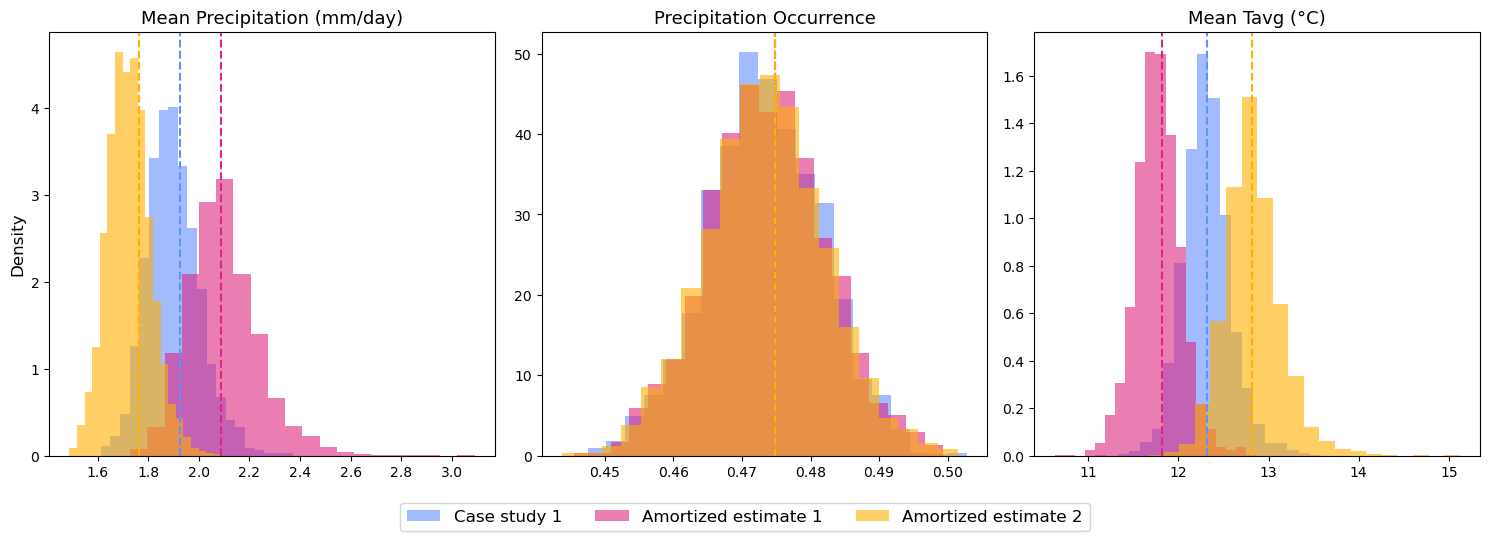

In [112]:
import matplotlib.pyplot as plt

# Colorblind-safe Paul Tol "Bright" palette
colors = {
    "result": "#648FFF",  # blue
    "result1": "#DC267F",              # magenta
    "result2": "#FFB000"           # orange
}

# Plot
titles = ["Mean Precipitation (mm/day)", "Precipitation Occurrence", "Mean Tavg (°C)"]

fig, axs = plt.subplots(
    1, obs_stats_target2.shape[0],
    figsize=(obs_stats_target2.shape[0] * 5, 5),
    layout="tight"
)

for i in range(obs_stats_target2.shape[0]):
    axs[i].hist(
        result.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["result"],
        label="Case study 1"
    )
    axs[i].hist(
        result1.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["result1"],
        label="Amortized estimate 1"
    )
    axs[i].hist(
        result2.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["result2"],
        label="Amortized estimate 2"
    )

    axs[i].axvline(
        obs_stats_target[i],
        color=colors["result"], linestyle="--", linewidth=1.5,
    )
    axs[i].axvline(
        obs_stats_target1[i],
        color=colors["result1"], linestyle="--", linewidth=1.5,
    )
    axs[i].axvline(
        obs_stats_target2[i],
        color=colors["result2"], linestyle="--", linewidth=1.5,
    )

    axs[i].set_title(titles[i], fontsize=13)
    #axs[i].grid(alpha=0.3)

#axs[0].set_xlabel("Mean Precipitation (mm/day)", fontsize=12)
#axs[1].set_xlabel("Precipitation Occurrence", fontsize=12)
#axs[2].set_xlabel("Mean Tavg (°C)", fontsize=12)
axs[0].set_ylabel("Density", fontsize=12)
#axs[1].set_ylabel("Density", fontsize=12)
#axs[2].set_ylabel("Density", fontsize=12)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Shared legend below the plots, with box
fig.legend(
    by_label.values(), by_label.keys(),
    loc="upper center", bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=False, ncol=4, frameon=True,
    fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_1_amortization.png", dpi=300, bbox_inches="tight")
plt.show()

In [113]:
@wxsbi.summarystats("precip", "precip occ.", "cumulative dry days", "Tavg")
def test_stats(prec, Tavg, **kwargs):
    pmean = jnp.mean(prec, axis = -1)
    pavgwet = jnp.mean(prec > 0, axis = -1)
    cdd = weathergen.utils.cumulative_dry_days(prec, axis=-1)
    Tavgmean = jnp.mean(Tavg, axis = -1)
    return jnp.stack([pmean, pavgwet, cdd, Tavgmean], axis = -1)

In [114]:
obs_stats_test = test_stats(**obs)
obs_stats_test

Array([1.6045674, 0.4748631, 3.149097 , 8.81644  ], dtype=float32)

In [115]:
simulator_test = wxsbi.build_simulator(wgen, test_stats, parallel = True)
cm_prior_test = wxsbi.get_rescaled_svi_posterior(guide, svi_result, scale_factor=2.5)

In [116]:
theta_prior, x_prior = wxsbi.simulate_from_sbi_prior(simulator_test, cm_prior_test)

INFO:wxsbi.wxsbi:Running 1000 simulations for SBI prior


In [117]:
df_test = pd.DataFrame(x_prior, columns=test_stats.names)
df_test

precip  precip occ.  cumulative dry days       Tavg
0    1.311288     0.406462             4.485927  10.015497
1    1.815320     0.513417             2.794025   7.964441
2    1.425184     0.384064             4.089818  10.922936
3    1.506813     0.531052             2.826073   8.731818
4    1.856260     0.470372             3.117666   5.948962
..        ...          ...                  ...        ...
995  1.695960     0.448193             3.314474  11.116910
996  2.123712     0.538719             2.814233   8.245821
997  1.629993     0.565444             2.523052   8.908271
998  1.583647     0.523713             2.820954   8.657867
999  1.699897     0.538226             2.734998   8.679549

[1000 rows x 4 columns]

- Increase average precip by 10%
- Increase precip frequency by 30%
- Incrase cumulative dry days by 30%; this is inconsistent with the previous two changes since it implies drier conditons.

In [118]:
obs_stats_target_test = obs_stats_test
obs_stats_target_test = obs_stats_target_test.at[0].mul(1.1)
obs_stats_target_test = obs_stats_target_test.at[1].mul(1.3)
obs_stats_target_test = obs_stats_target_test.at[2].mul(1.3)
obs_stats_target_test

Array([1.7650242, 0.617322 , 4.093826 , 8.81644  ], dtype=float32)

As expected, the anomaly can be seen in the pair plot for CDD and precip occurrence.

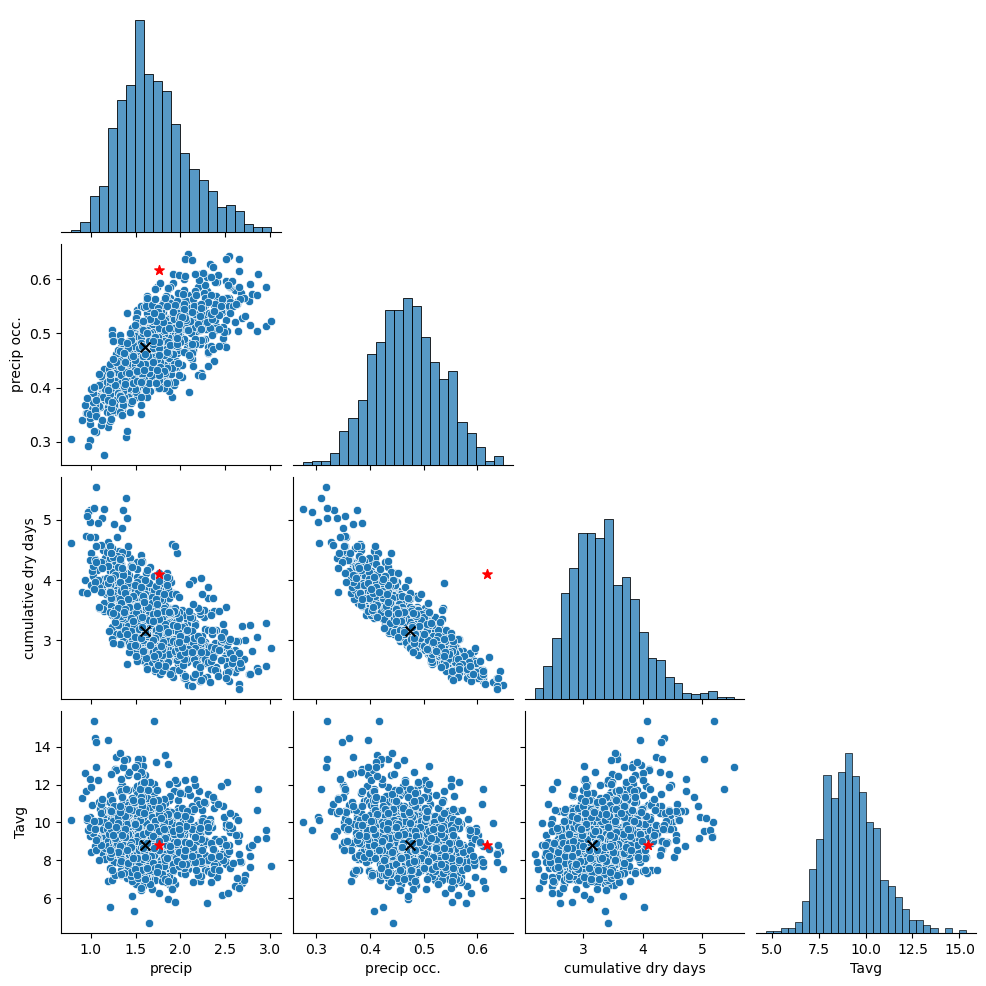

In [119]:
grid = sns.pairplot(df_test, corner=True)
for i in range(len(obs_stats_test)):
    for j in range(i+1, len(obs_stats_test)):
        grid.axes[j, i].scatter(obs_stats_test[i], obs_stats_test[j], color="black", marker="x", s=50.0, zorder=10)
        grid.axes[j, i].scatter(obs_stats_target_test[i], obs_stats_target_test[j], color="red", marker="*", s=50.0, zorder=10)